In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from gempy import coKriging
from gempy import GridClass
import pandas as pd
from numpy import random
import sklearn.preprocessing as skp
import pymc3 as pm
import theano.tensor as T

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [2]:
SED_f = gp.coKriging.theano_sed()

In [3]:
def create_sgs_dataframe(geomodel, grid, formation):
    """
    Method to create a new pandas dataframe combining Input Data for SGS CoKriging
    Does not include property data for variogram analysis and interpolation. Thus independent
    of amount of Input properties.
    Args:
        geomodel (numpy.ndarray): lithological block model created with gempy
        grid (gempy.data_management.GridClass): Grid created for geologic model
        formation (int): Number of formation to perform CoKriging on
    Returns
        pandas.dataframe: Combined dataframe with all relevant data
    """
    
    # convert lith block values to int, need to do this properly - uncorrect as of now
    lith_block_int = np.round(lith_block)
    
    # create the dataframe and populate with data
    d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0]}
    df_cokr = pd.DataFrame(data=d)
    
    df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
    df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
    del df_sgs_grid['index'] # reset indices
    
    return df_sgs_grid

In [4]:
def create_synthetic_Input_data(n_prop, n_samples, grid):
    '''
    This Part is used to create synthetic Input data. It is possible to vary the number of properties
    and the number of samples. Right now every assigned value is a random value between 0 and 100.
    Data is thus in no way spatially correlated, which makes the Kriging kind of useless, but works for
    testing purposes. Only an isotopic case is realized. Max 10 properties can be used due to a.
    Args: 
        n_prop (int): Number of properties that we have data for
        n_samples (int): Number of sample locations, were we have data for every property (isotopic)
    Returns:
        df_prop(pandas.dataframe): dataframe containing x,y,z coordinates and data for n properties
    '''
    # copy to leave original grid intact
    data_loc_aux = df_cokr_cut.copy()

    # create dataframe with coordinates and n properties
    d = ['X', 'Y', 'Z']
    df_prop = pd.DataFrame(columns=d)
    df_prop

    a=['prop1','prop2','prop3','prop4', 'prop5','prop6','prop7','prop8','prop9','prop10']

    for t in range (n_prop):
        df_prop[a[t]]=""

    df_prop

    for i in range(n_samples):
            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(data_loc_aux))
            random_coord = np.array([data_loc_aux.loc[rand_pos,'X'],data_loc_aux.loc[rand_pos,'Y'],data_loc_aux.loc[rand_pos,'Z']])

            # delete point from the df sgs_grid_calc
            data_loc_aux = data_loc_aux.drop([rand_pos])
            data_loc_aux = data_loc_aux.reset_index() # reset indicies
            del data_loc_aux['index'] #reset indices

            # pick random coordinate from grid
            data_point=([random_coord[0], random_coord[1], random_coord[2]])

            # put random data in 
            #for r in range(n_prop):
            #    data_point.append(np.random.randint(1,100))
            
            data_point.append(0.00001*np.random.normal(1,1)/35)
            data_point.append((13.7+np.random.normal(20,3))*3)
            data_point.append(np.random.normal(3,10)*2)
            data_point.append(np.random.normal(100,50)+2.23462)
            data_point.append(5.234*np.random.normal(25,2))

            df_prop.loc[i]=data_point
            # create random data for the properties

    return df_prop

In [5]:
def select_closest_points(coord, df):
    """
    Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
    time
    Args:
        coord (np.array): coordinates of point
        df (pandas.dataframe): dataframe containing coordinated and properties
    Returns
        df_cut (pandas.dataframe): dataframe containing only the 50 closest points
    """
    
    selected_coord_data = df[['X', 'Y', 'Z']]
    # selected_values_data = df[df.columns.difference(['X', 'Y', 'Z'])].as_matrix()
    
    dist = SED_f(selected_coord_data, coord) # Miguels distance function, applied to input data
    
    for r in range(100, 5000, 100):
        closest_points = (dist < r).any(axis=1)
        if closest_points.sum() > 50:
            break
    
    return closest_points

In [6]:
def cross_cov_sample(df, exp_var, lags):
    """
    method to pick sample from Miguels crazy crossvariogram fitting, mostly copied
    """
    n_exp = 2
    n_gaus = 2
    n_var = df.columns.shape[0]
    n_basis_f = n_var * (n_exp + n_gaus)
    prior_std_reg = df.std(0).max() * 10
    #
    range_mu = lags.mean()

    # Because is a experimental variogram I am not going to have outliers
    nugget_max = df.values.max()
    # print(n_basis_f, n_var*n_exp, nugget_max, range_mu, prior_std_reg)
    # pymc3 Model
    with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        sigma = pm.HalfCauchy('sigma', beta=prior_std_reg, testval=1., shape=n_var)

        psill = pm.Normal('sill', prior_std_reg, sd=.5 * prior_std_reg, shape=(n_exp + n_gaus))
        range_ = pm.Normal('range', range_mu, sd=range_mu * .3, shape=(n_exp + n_gaus))
        #  nugget = pm.Uniform('nugget', 0, nugget_max, shape=n_var)

        lambda_ = pm.Uniform('weights', 0, 1, shape=(n_var * (n_exp + n_gaus)))

        # Exponential covariance
        exp = pm.Deterministic('exp',
                               # (lambda_[:n_exp*n_var]*
                               psill[:n_exp] *
                               (1. - T.exp(T.dot(-lags.as_matrix().reshape((len(lags), 1)),
                                                 (range_[:n_exp].reshape((1, n_exp)) / 3.) ** -1))))

        gaus = pm.Deterministic('gaus',
                                psill[n_exp:] *
                                (1. - T.exp(T.dot(-lags.as_matrix().reshape((len(lags), 1)) ** 2,
                                                  (range_[n_exp:].reshape((1, n_gaus)) * 4 / 7.) ** -2))))

        func = pm.Deterministic('func', T.tile(T.horizontal_stack(exp, gaus), (n_var, 1, 1)))

        func_w = pm.Deterministic("func_w", T.sum(func * lambda_.reshape((n_var, 1, (n_exp + n_gaus))), axis=2))
        #           nugget.reshape((n_var,1)))
        '''
        for e, cross in enumerate(df.columns):
            # Likelihoods
            pm.Normal(cross + "_like", mu=func_w[e], sd=sigma[e], observed=df[cross].as_matrix())
        '''
    return model

    

In [7]:
def perform_sgs(property_data, sgs_grid, exp_var):
    """
    Method to perform the SGS run, creating a new dataframe with the resulting grid, 
    containing the interpolated data fro the CoKriging
    Args:
        property_data (pandas.datframe): frame containing property data with corresponding X,Y,Z coordinates
        sgs_grid (pandas.dataframe): frame containing grid, meaning all X,Y,Z coordinates in domain 
    Returns:
        Result: Dataframe containg all interpolated values with corresponding coordinates       
    """
    
    # Normalization, compared to Miguels code all properties "have" to be used
    # Turn Nans to 0, workaround
    exp_var_aux = exp_var.copy()
    exp_var_aux.fillna(value=0, inplace=True)
    aux = exp_var_aux.drop('lags', axis=1)
    
    scaled_data = pd.DataFrame(skp.minmax_scale(aux))

    # Nuggets
    nuggets = scaled_data.iloc[0].as_matrix()
    processed_data = scaled_data - nuggets
    
    lags=exp_var['lags']
    
    model = cross_cov_sample(scaled_data, exp_var, lags)
    if True:
        with model:
            start = pm.find_MAP()  # Find starting value by optimization
            step = pm.Metropolis()
            #db = pm.backends.SQLite('SQtry.sqlite')
            trace = pm.sample(100, step, init=start, progressbar=True, njobs=1)
    if False:
        sgs.plot_cross_covariance(iter_plot=1800)
        
        
    # new dataframe for all results
    results = pd.DataFrame(columns=property_data.columns)
    n_var = len(results.columns)-3
    
    # both Input dfs should not be changed
    df_prop_calc = property_data.copy() #copy dataframe for appending results for SGS
    df_sgs_grid_calc = sgs_grid.copy() #copy of grid frame to delete data
    
    for i in range(0, len(sgs_grid)):
        
        # choose random point from df_sgs_grid_calc
        rand_pos = np.random.randint(0,len(df_sgs_grid_calc))
        random_coord = np.array([df_sgs_grid_calc.loc[rand_pos,'X'],df_sgs_grid_calc.loc[rand_pos,'Y'],df_sgs_grid_calc.loc[rand_pos,'Z']])
        
        # workaround to turn coord into df to make it work with Miguels Code
        coord_aux={'X':[random_coord[0]], 'Y':[random_coord[1]], 'Z':[random_coord[2]]}
        rand_coord_df=pd.DataFrame(data=coord_aux)
        
        # delete point from the df sgs_grid_calc
        df_sgs_grid_calc = df_sgs_grid_calc.drop([rand_pos])
        df_sgs_grid_calc = df_sgs_grid_calc.reset_index() # reset indicies
        del df_sgs_grid_calc['index'] #reset indices
        
        # only select n closest points for Cokriging,best by selection to make it work with miguels code
        df_prop_calc_close = select_closest_points(rand_coord_df, df_prop_calc)
        
        # perform the CoKriging interpolation on this point
        kriging_results = CoKriging_real(rand_coord_df, df_prop_calc, df_prop_calc_close, n_var, nuggets, trace) 
        
        #just for testing purposes, we get this from the Kriging Results
        # good enough, lets see what the Kriging results really look like
        krig_mean = np.ndarray(shape=(n_var,2))
        krig_std = np.ndarray(shape=(n_var,2))
        
        # set coordinates in result array
        new_interpolated_point = ([random_coord[0], random_coord[1],random_coord[2]])
        
        # add property interpolation to results array, depends a little bit on form of Kriging results
        for j in range(n_var):
            new_interpolated_point.append(np.random.normal(krig_mean[j][0],krig_std[j][1]))
                            
        # append result to df_prop_calc to use for further SGS
        df_prop_calc.loc[len(df_prop_calc)]=new_interpolated_point
        
        # append results to final results dataframe that will be returned
        results.loc[len(results)]=new_interpolated_point
        
    return results

In [8]:
#wtf

def CoKriging_real(coord_to_inter, df_prop_data, selection, n_properties, nuggets, trace):
    """
    Method to perform Cokriging at one point based on a set of input points, considering multiple variables
    Args:
        coord_to_interpolate: X,Y,Z coordinates of point where properties should be interpolated
        property_data: dataset of property data for interpolation (including coordinates)
        variogram_data (?)
    Returns:
        x (np.array): Array with results of interpolation, including x,y,z coord and interpolated property data
    """
    
    # Select input data and compute its euclidean distances
    selected_coord_data = df_prop_data[selection][['X', 'Y', 'Z']]
    selected_values_data = df_prop_data[selection][df_prop_data.columns.difference(['X', 'Y', 'Z'])].as_matrix()
    h_A = SED_f(selected_coord_data, selected_coord_data)
    
    # Select points of grid to interpolate and compute the euclidean distances respect the input data
    selected_grid_to_inter = coord_to_inter 
    h_b = SED_f(selected_coord_data, selected_grid_to_inter)
    
    # Nuggets are now in as parameter
    # as well as trace
    n_properties = 25
    # should be correct
    n_var = int(np.sqrt(n_properties)) 
    
    # no idea but thats Miguels standard
    n_exp = 2
    n_gauss = 2

    # why - I am supposed to just pick medium trace I think
    # Choose a random trace to conserve the covariance uncertainty of the regression
    sample = np.random.randint(trace['weights'].shape[0] - 100, trace['weights'].shape[0])

    # If input data is correct, this can stay
    # Compute cross-covariances
    cov_h = coKriging.cross_covariance(trace, h_A, sample=sample,
                                nuggets=nuggets, n_var=n_var, n_exp=n_exp, n_gaus=n_gauss, ordinary=True)
    cov_b = coKriging.cross_covariance(trace, h_b, sample=sample, nuggets=nuggets, n_var=n_var, n_exp=n_exp,
                                n_gaus=n_gauss,
                                ordinary=True)
    
    
    # If input data is correct, this can stay
    # Solve kriging system
    try:
        k_weights = np.linalg.solve(cov_h, cov_b)
        print("k_weights:", k_weights)
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            k_weights = np.zeros((len(cov_b), 1))
            print(cov_h.shape, "cov_h:", cov_h)
        else:
            raise
    
    # k_weights = np.linalg.solve(cov_h, cov_b)
    
    # dont know what this is and if its necessary if i do not take random covariance function
    # Number of points to interpolate
    npti = selected_grid_to_inter.shape[0]

    # dont know what this is and if its necessary if i do not take random covariance function
    # Repeat the input data for every point to interpolate
    svd_tmp = np.tile(np.repeat(selected_values_data, npti, axis=1), (n_var, 1))

    # this should work
    # Sol ordinary kriging mean
    k_mean = (svd_tmp * k_weights[:-n_var]).sum(axis=0)

    # this should work
    # Sol ordinary kriging std
    k_std = svd_tmp.std(axis=0) - (k_weights * cov_b)[:-n_var].sum(axis=0) +\
            (k_weights * cov_b)[-n_var:].sum(axis=0)

    # not sure if the following part is necessary
    '''assert all(k_std) > -10, "A standard deviation of kringing is really off. Check nothing is wrong"
    # Set negatives to 0
    k_std[k_std < 0] = 0.1

    # Check the results make sense else take another sample and recompute
    import scipy
    l_low, l_high = scipy.stats.norm.interval(.95, loc=np.mean(selected_values_data, axis=0),
                                                scale=np.std(selected_values_data, axis=0))

    if not np.all((k_mean > l_low) * (k_mean < l_high)):

        k_mean, k_std, cov_h, cov_b, k_weights, sample = self.solve_kriging(selection_A, selection_b)
        self._recursion_check += 1
        assert self._recursion_check<500, 'Too many recursions. Probably something goes wrong'

    else:
        self._recursion_check = 0
        values_interp = np.random.normal(k_mean, k_std)'''

    return k_mean, k_std, cov_h, cov_b, k_weights#, sample

In [9]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_interfaces") # importing point-positional interface data

In [10]:
# gp.get_data(geo_data)

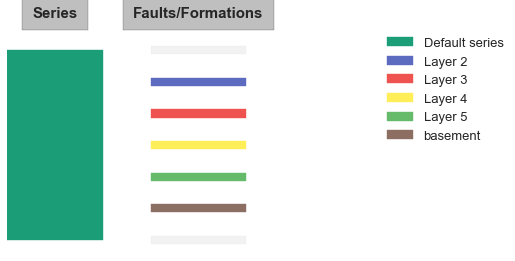

In [11]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

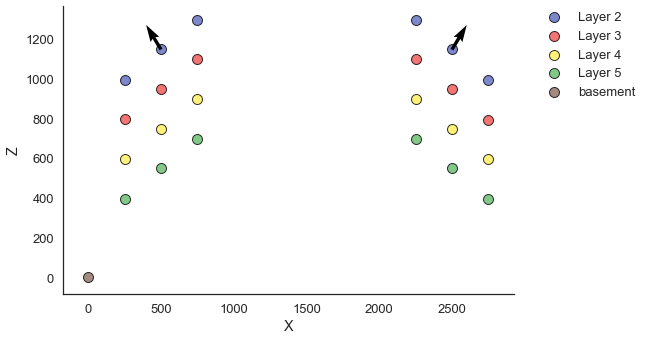

In [12]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [13]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')
#print(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [14]:
lith_block, fault_block = gp.compute_model(interp_data)

In [15]:
df_cokr_cut = create_sgs_dataframe(lith_block[0],geo_data.grid, formation=3)

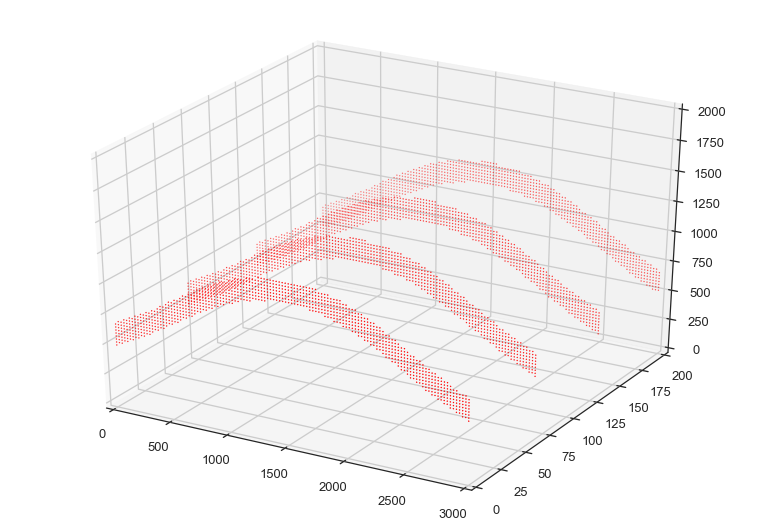

In [16]:
# visualization of grid, cut down to one lithology
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')

In [17]:
#section plotted in classical gempy plot_section for comparison

#%matplotlib inline
#gp.plotting.plot_section(geo_data, lith_block[0], cell_number=0,  direction='y', plot_data=False)

In [18]:
number_of_properties=5
number_of_samples=1000

df_prop = create_synthetic_Input_data(number_of_properties, number_of_samples, df_cokr_cut)
df_prop.head()

,X,Y,Z,prop1,prop2,prop3,prop4,prop5
0,1537.5,199.166672,1288.713135,1.772793e-07,113.966881,23.824526,77.619467,128.638641
1,1862.5,133.055557,1163.185669,4.587791e-07,104.283876,13.903562,101.581011,134.678081
2,2137.5,0.833333,1087.869141,3.913049e-08,107.250952,-12.297888,106.675232,130.346323
3,1162.5,199.166672,1213.396606,1.180836e-07,90.876851,1.560763,93.005438,145.670641
4,37.5,0.833333,686.181458,3.460609e-08,96.433145,-3.540506,164.896336,125.583530


In [19]:
# Dirty workaround to be able to compute variograms for n properties
a=['prop1','prop2','prop3','prop4', 'prop5','prop6','prop7','prop8','prop9','prop10']
properties = a[:number_of_properties]

exp_var = gp.coKriging.compute_crossvariogram(df_prop, properties)
exp_var.head()

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,prop1-prop1,prop1-prop2,prop1-prop3,prop1-prop4,prop1-prop5,prop2-prop1,prop2-prop2,prop2-prop3,prop2-prop4,prop2-prop5,...,prop4-prop2,prop4-prop3,prop4-prop4,prop4-prop5,prop5-prop1,prop5-prop2,prop5-prop3,prop5-prop4,prop5-prop5,lags
0,0.0,5136.004094,235.57911,6199.409212,8739.808158,5136.004094,0.0,4738.76624,1133.794896,567.095723,...,1133.794896,5791.758284,0.0,1615.667357,8739.808158,567.095723,8146.665357,1615.667357,0.0,1.000000
1,0.0,5136.004094,235.57911,6199.409212,8739.808158,5136.004094,0.0,4738.76624,1133.794896,567.095723,...,1133.794896,5791.758284,0.0,1615.667357,8739.808158,567.095723,8146.665357,1615.667357,0.0,1.064786
2,0.0,5136.004094,235.57911,6199.409212,8739.808158,5136.004094,0.0,4738.76624,1133.794896,567.095723,...,1133.794896,5791.758284,0.0,1615.667357,8739.808158,567.095723,8146.665357,1615.667357,0.0,1.133769
3,0.0,5136.004094,235.57911,6199.409212,8739.808158,5136.004094,0.0,4738.76624,1133.794896,567.095723,...,1133.794896,5791.758284,0.0,1615.667357,8739.808158,567.095723,8146.665357,1615.667357,0.0,1.207222
4,0.0,5136.004094,235.57911,6199.409212,8739.808158,5136.004094,0.0,4738.76624,1133.794896,567.095723,...,1133.794896,5791.758284,0.0,1615.667357,8739.808158,567.095723,8146.665357,1615.667357,0.0,1.285433


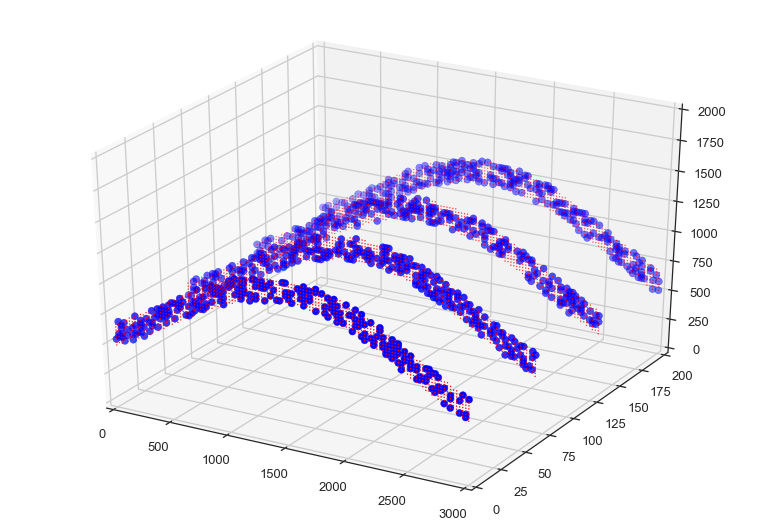

In [20]:
# visualization of grid, cut down to one lithology, as well as property Input data from dataframe
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)

In [ ]:
%%time
results = perform_sgs(df_prop, df_cokr_cut, exp_var)

logp = -74.663, ||grad|| = 0.0017996: 100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 1151.70it/s]
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [weights_interval__]
>Metropolis: [range]
>Metropolis: [sill]
>Metropolis: [sigma_log__]
100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 984.68it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


k_weights: [[ 0.0095263  -0.00592462 -0.0006934   0.00230018  0.00174065]
 [ 0.01167879 -0.00792937  0.00856629  0.00052856  0.00268339]
 [ 0.01252836 -0.00809298 -0.00104667  0.00311117 -0.00012358]
 ...
 [-0.07761297 -0.10241999 -0.0413227  -0.05336949 -0.03976325]
 [-0.0415081  -0.06808953 -0.0597299  -0.07434823 -0.05975824]
 [-0.04161382 -0.04932071 -0.05745661 -0.03706765 -0.08652156]]
k_weights: [[ 0.07555603 -0.65300397 -0.00219079 -0.049111   -0.0044019 ]
 [ 0.15276857 -0.82652698  0.02170887 -0.05575626 -0.04935876]
 [ 0.23097429 -1.36021486  0.11292653 -0.16429208 -0.085332  ]
 ...
 [-0.09628749 -0.15477655 -0.06066564 -0.07497214 -0.05952207]
 [-0.07033005 -0.0802649  -0.08826673 -0.09832092 -0.11023528]
 [-0.07320766 -0.14740027 -0.05903328 -0.05897904 -0.09730903]]
k_weights: [[ 1.25894258 -0.00318126  1.45265737 -0.43996072 -0.43934038]
 [ 0.15883589  0.20828131  0.40106574 -0.19594013 -0.17388774]
 [ 0.29273121 -0.07548677  0.33857084 -0.08655107 -0.08450971]
 ...
 [-0.

   2.26586561e-03]]
k_weights: [[ 7.70506185e-03 -3.68120606e-03  2.39340615e-03  2.36121138e-03
   3.35271578e-03]
 [-2.32774458e-02  6.38316652e-03 -9.06221240e-03 -9.06766435e-03
  -1.70582096e-02]
 [ 6.34518101e-03 -4.07685681e-04  7.11521575e-04  4.92509935e-06
  -1.57603094e-04]
 ...
 [-1.47853858e-01 -2.35869507e-01 -7.29906040e-02 -1.09063796e-01
  -7.76653365e-02]
 [-1.26053736e-01 -1.92230851e-01 -2.14325355e-01 -1.43255078e-01
  -1.99421389e-01]
 [-1.53182999e-01 -8.29687705e-02 -1.21393696e-01 -7.75271093e-02
  -1.60748283e-01]]
k_weights: [[-5.26417595e-14 -1.35907075e-13  1.26202525e-14 -3.62201947e-14
   2.49377809e-15]
 [ 5.15143847e-16 -2.37078676e-15  4.85622493e-15 -8.50705623e-16
  -3.19973837e-15]
 [ 1.91710674e-14 -2.88142135e-14  9.91796548e-15 -1.50255847e-15
   2.60808903e-13]
 ...
 [ 2.87970110e-15 -9.97483056e-16 -1.59290103e-14 -2.79287798e-15
  -8.38720321e-15]
 [ 7.95929915e-16 -3.07863145e-15 -1.81618668e-14 -1.20947001e-15
  -1.30063380e-14]
 [ 1.3772675

  -1.10164792e-01]]
k_weights: [[  89.17646662 -582.47332948   -6.54212885 -212.5245776    63.0778353 ]
 [  15.53701813 -240.68124631    0.86077314  -55.99445942   10.49993847]
 [  -0.8715108  -111.93444142   -1.79115705  -74.49879743    9.10021358]
 ...
 [  -6.37742572   14.07561708   -1.77570299  -13.36739817  -12.44747231]
 [  -5.49758548   12.20241348   -1.59108043  -11.25147477  -10.41148301]
 [  -5.3102402    11.81470894   -1.54262439  -10.73949185   -9.94790151]]
k_weights: [[ 3.55553867e-03 -7.91978223e-04  6.21793644e-04  8.12183712e-05
   3.41959674e-03]
 [-3.34176237e-03  7.72027633e-04 -4.43572850e-03 -1.55895538e-04
   1.16081898e-03]
 [-8.71888432e-02  1.95220019e-02 -5.55516234e-02 -7.26438172e-03
  -7.62323433e-02]
 ...
 [-2.46783508e-02 -3.59413466e-02 -1.99872536e-02 -2.11555004e-02
  -1.28801664e-02]
 [-1.98759828e-02 -2.80287891e-02 -2.57920947e-02 -2.14778460e-02
  -3.21445716e-02]
 [-1.71458081e-02 -1.84927008e-02 -1.52581896e-02 -1.52610880e-02
  -1.95824281e-02]

 [-0.17518594  0.0201046  -0.1590071  -0.01062585 -0.02556014]]
(600, 600) cov_h: [[ 1.         -9.04105185 -9.04114519 ...  0.          0.
   0.        ]
 [-9.04105185  1.         -9.02690928 ...  0.          0.
   0.        ]
 [-9.04114519 -9.02690928  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-2.79034171e-15 -7.22644448e-16 -3.38570249e-15 -4.07183694e-15
  -4.31926895e-16]
 [ 4.17714350e-15 -2.61835498e-15  6.56572294e-15  4.53291377e-15
   2.53313173e-15]
 [-2.19981400e-14  1.39098310e-14 -2.89442093e-14 -2.73219232e-14
  -1.68948377e-15]
 ...
 [-2.46947133e-15  1.04184362e-15 -8.29281857e-15 -7.89107080e-15
  -7.93241562e-16]
 [ 6.57263033e-15 -3.25414921e-15 -4.53551816e-16  2.70945279e-15
   2.20659012e-15]
 [-4.70664506e-16 -1.30382248e-16

  -4.96152690e-01]]
k_weights: [[-7.57163212e+03 -7.32946984e+01 -2.10477188e+03  2.01093624e+02
   7.57703014e+01]
 [-2.08113031e+03  6.86738266e+01  1.11524978e+03  2.24735769e+02
   1.40122650e+02]
 [-3.41791252e+02  4.88609867e+00  4.00153804e+01  1.88358768e+01
   2.44625123e+01]
 ...
 [-4.73113341e+01  3.61206651e-01 -1.63674299e+01  3.39783354e+00
  -4.10413950e-01]
 [-4.17707941e+01  3.21668512e-01 -1.45521902e+01  2.97916272e+00
  -5.05852009e-01]
 [-4.07949853e+00 -5.04383886e-02 -1.46649044e+00  1.56138763e-01
  -6.20917062e-03]]
k_weights: [[-1.74717939e-15 -9.44172422e-17  1.63226016e-15  6.87632359e-16
   4.55449201e-17]
 [-4.38599249e-16  8.63173029e-16  5.50313907e-16 -3.02435247e-16
   1.22617838e-16]
 [ 1.60514740e-15  1.26436582e-15  1.31234149e-15  7.50052896e-16
   1.17962190e-15]
 ...
 [-2.28350146e-15 -1.75895064e-15 -2.97263826e-16  5.69125237e-16
  -3.30187929e-15]
 [-2.61601969e-15 -1.28255314e-15 -2.21738075e-16  1.41620211e-15
  -7.74668672e-15]
 [-2.3973080

   2.36510932e+00]]
k_weights: [[ 17135.83645016  -6322.91237495  13116.12756334  -3968.3347685
   -2683.63929617]
 [-21644.94611271   4818.14300605   5059.91811209   4999.37237412
  -38884.03145541]
 [ -5696.17784321 -17719.29162109   6482.7452212    6080.8351768
   14871.50243781]
 ...
 [  -122.32440735   -318.95678816     63.06099089     62.52355296
    -198.86903874]
 [   -86.011586     -223.97215118     44.37654901     43.84208467
    -140.06079301]
 [   -84.97091167   -220.69198907     43.81943342     43.65936626
    -136.78895436]]
(525, 525) cov_h: [[ 1.         -9.79700326 -9.78464897 ...  0.          0.
   0.        ]
 [-9.79700326  1.         -7.66712194 ...  0.          0.
   0.        ]
 [-9.78464897 -7.66712194  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.    

   1.01551146e-14]]
k_weights: [[ 12.43921427 -31.54956172  16.72879922   5.10532503  -2.02355477]
 [  6.01579598 -46.59640853  -7.77574837   4.58182879  -5.46148707]
 [ -9.70813277  47.79656776 -25.66024779  -1.64225892  -8.06299513]
 ...
 [ -1.56356781   2.98474307  -1.5465716    0.57251211  -2.38501833]
 [ -1.7975413    3.59481683  -1.84965394   0.66961407  -2.66253951]
 [ -1.65708439   3.32331453  -1.70885958   0.64845173  -2.46899894]]
k_weights: [[ -4.27053858   8.72268112  21.58693635  25.03498202  25.99530004]
 [ -0.6293431  -12.50793034   0.21636416 -17.39547311  39.74946412]
 [ -6.03172919 -25.41558621 -58.89210521 -51.24103111 -35.73474859]
 ...
 [-10.12834345  -7.78589117   4.32196837   5.53860222   4.83909211]
 [-10.81630905  -8.40018705   4.42434227   5.78979577   4.77488216]
 [ -9.64330301  -7.22201868   4.22240335   4.94428667   4.09482954]]
k_weights: [[-2.56279937e+06 -1.01256288e+07  3.53870851e+02  8.96625049e+02
   3.99185827e+06]
 [-3.49379984e+06  5.64086391e+06 

   0.        ]]
k_weights: [[   3.87515169  153.3760821   -56.96748259   32.25070907   -7.69623901]
 [ -56.79223073 -444.13165627   47.20490343  -53.72629609 -322.99335285]
 [  -0.86802002   22.62272354  -26.56380378   51.80779235 -112.76408301]
 ...
 [  -1.40240616    6.685214     -0.921037      3.23822616  -58.93564659]
 [  -6.38924612   30.39454197   -5.68675706   11.64243997  -64.06615106]
 [  -4.39010008   20.55367      -3.93181332    7.79239009  -37.37669313]]
k_weights: [[-1.61872675e+03  1.63306506e+02 -1.48052729e+03 -2.56828571e+01
   2.22773485e+02]
 [-5.54368123e+02  2.24164885e+02 -1.43481865e+03 -3.25878460e+01
  -1.60212281e+02]
 [-7.46658323e+02 -2.21179088e+02  2.83256310e+03 -2.51874150e+00
  -2.96070404e+02]
 ...
 [-1.73372507e+00 -2.97244628e+00 -2.87273205e+00 -5.65466042e+00
   1.25496850e+01]
 [ 1.56877028e+00 -1.13471185e+00 -9.65461158e+00 -4.76080100e+00
   1.24720827e+01]
 [ 5.44007031e+00  9.34561776e-01 -1.95455318e+01 -5.83431703e+00
   1.89615303e+01]]
k_

  -1.31716491e+01]]
(550, 550) cov_h: [[ 1.         -7.5541227  -8.22672409 ...  0.          0.
   0.        ]
 [-7.5541227   1.         -8.22627701 ...  0.          0.
   0.        ]
 [-8.22672409 -8.22627701  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 4.36496737e-01  2.39574666e+01 -3.89588349e+01  1.07797863e+00
   1.71434481e+02]
 [-9.55516163e-01 -2.79645435e-01 -2.69446004e+00 -3.91357742e-01
   1.01270115e+02]
 [ 9.12558616e+00  4.92134383e+00 -1.59104808e+01  3.56629238e+00
   8.09674701e+02]
 ...
 [ 3.11430630e-01  5.77081042e-01 -2.11828756e-01  7.51455805e-02
   9.33666129e+00]
 [ 4.33198148e-01  2.86825745e-01 -5.54095414e-01 -1.35408888e-01
   8.23145091e+00]
 [ 1.08115621e+00  2.34873680e-01 -1.56135575e+00 -4.41381001e-01
   1.472913

   -125.64657688]]
k_weights: [[ 3.07233633e+02 -1.27730469e+01  3.87874647e+01  3.37164044e+00
  -7.42266402e+02]
 [-3.12765001e+01  7.97915677e+00 -5.10541781e+01  8.47655042e+00
   1.44151944e+02]
 [ 3.23493545e+01 -1.84546158e+01 -5.31374119e+00  2.35456944e+00
  -1.28525192e+01]
 ...
 [-7.66185676e+00  2.54715503e+00  5.17653557e+00 -2.17529246e-01
   1.06205194e+01]
 [-3.96306224e+00  1.34831181e+00  2.35663933e+00  1.55080638e-01
   4.29734054e+00]
 [-6.00215143e+00  2.02855618e+00  3.84815253e+00  2.11620737e-02
   7.36565294e+00]]
k_weights: [[ 1822.07273594  1192.45171567  1537.75411706  2155.80883365
    533.15594397]
 [  117.56071054   161.6571246   -481.71747202  -552.27567029
   -109.52468137]
 [    6.99417439  1895.44419596 -1669.12771812 -1689.85892361
   -184.83832228]
 ...
 [ -258.05184798  -659.2746626    521.51320808  -343.63198372
    267.77128265]
 [ -155.95751042  -396.9908774    315.52727894  -209.73113107
    159.93302181]
 [ -167.29656724  -426.44257232   338.

  -1.31585784e+02]]
(495, 495) cov_h: [[  1.         -11.7844491  -11.67442281 ...   0.           0.
    0.        ]
 [-11.7844491    1.         -11.78369222 ...   0.           0.
    0.        ]
 [-11.67442281 -11.78369222   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[-3.15734222e-13  2.29790916e-11 -1.23354525e+02  1.84181039e+01
  -3.40454703e+02]
 [ 1.66205643e-13  6.14189561e-14  4.26903308e+01 -2.16663570e+01
   8.92911030e+02]
 [-1.29832428e-14  1.12008017e-11  6.41743189e+01  8.78464639e+00
  -1.09793318e+02]
 ...
 [-1.98860092e-15  1.97975091e-13 -2.19010031e-01  6.63471437e-01
   3.81507319e+01]
 [-4.14479481e-15  3.86280362e-14 -6.22127116e-01  7.29006329e-01
   4.70367185e+01]
 [-4.41774376e-15 -1.16243766e-13 -1.3205

   2.83084894e+00]]
(435, 435) cov_h: [[ 1.         -8.6576136  -8.66196392 ...  0.          0.
   0.        ]
 [-8.6576136   1.         -8.66217969 ...  0.          0.
   0.        ]
 [-8.66196392 -8.66217969  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(555, 555) cov_h: [[  1.         -11.8294694  -11.79545018 ...   0.           0.
    0.        ]
 [-11.8294694    1.         -11.7843725  ...   0.           0.
    0.        ]
 [-11.79545018 -11.7843725    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[ 1.3525

   0.        ]]
k_weights: [[ 3.21838151e+00  3.98674812e+01 -2.82587297e+00  1.44305965e+01
   2.63427958e+02]
 [ 7.75629005e+00 -6.14072787e+01  1.97672674e+01  3.05245461e+01
  -4.58784559e+02]
 [ 9.44335217e+00  2.02553317e+01 -2.64155715e+00 -2.55891214e+01
   1.43877517e+02]
 ...
 [-1.22188435e-01 -4.89890992e-01 -6.75826110e-02 -2.96339945e-01
  -4.85191621e+00]
 [-4.22000604e-01  3.97228396e-01 -4.90117758e-01 -7.40793088e-01
  -1.74636846e+01]
 [-2.07945798e-01 -1.20971017e-01 -1.77083062e-01 -4.17301367e-01
  -1.02049274e+01]]
(485, 485) cov_h: [[ 1.         -5.74512779 -5.76279074 ...  0.          0.
   0.        ]
 [-5.74512779  1.         -5.75914339 ...  0.          0.
   0.        ]
 [-5.76279074 -5.75914339  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   0.        ]]
(645, 645) cov_h: [[  1.         -11.25677969 -11.25541152 ...   0.           0.
    0.        ]
 [-11.25677969   1.         -10.52455705 ...   0.           0.
    0.        ]
 [-11.25541152 -10.52455705   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[-4.23949340e+01  2.76641072e+01 -1.43763575e+01  5.71648255e+01
  -1.22929923e+02]
 [ 2.66948464e+01  1.00662160e+01  7.97975814e+00 -1.09137734e+01
   6.06455238e+01]
 [ 6.73534874e+16 -1.13389407e+16  1.26768344e+16 -1.93403259e+16
   1.18245456e+17]
 ...
 [-1.38144552e+00  2.29077111e-01 -2.02576151e+00  2.11090592e-01
  -3.48664077e-01]
 [ 6.25416178e-02 -2.35162405e-01 -3.23749953e-01 -3.71116595e-01
   1.92725011e-01]
 [-8.24402086e-02 -1.69643060e-01 -4.15128490

    0.        ]]
(585, 585) cov_h: [[ 1.         -6.5031537  -6.50241049 ...  0.          0.
   0.        ]
 [-6.5031537   1.         -6.30470317 ...  0.          0.
   0.        ]
 [-6.50241049 -6.30470317  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-4.32685293e-12  3.27681523e+02  1.08255926e+02  4.47807636e+01
  -6.35733729e+03]
 [ 8.40768123e-12 -5.19032092e+02 -5.50721678e+01  4.35108983e+02
   1.88551678e+03]
 [ 3.00375938e-12 -2.95770915e+02  9.85701737e+01 -3.12704544e+01
   2.25874659e+03]
 ...
 [ 1.47012037e-14  2.00217821e-01  4.80812435e-01  7.72129431e-01
  -2.66947356e+01]
 [ 1.71320126e-14  3.49685819e-01  1.78857490e-01  1.01079989e+00
  -1.65165478e+01]
 [ 1.11843662e-14  3.70742972e-01  3.03544308e-02  2.95043498e-01
  -1.03078211e

   0.        ]]
(550, 550) cov_h: [[ 1.         -5.18779718 -5.18270648 ...  0.          0.
   0.        ]
 [-5.18779718  1.         -5.18889582 ...  0.          0.
   0.        ]
 [-5.18270648 -5.18889582  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(480, 480) cov_h: [[ 1.         -8.58044874 -8.93585901 ...  0.          0.
   0.        ]
 [-8.58044874  1.         -8.08290033 ...  0.          0.
   0.        ]
 [-8.93585901 -8.08290033  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(765, 765) cov_h: [[ 1.         -7.0647179  -7.05883905 ... 

  -1.95900622e+03]]
(525, 525) cov_h: [[ 1.         -9.03850543 -9.04098221 ...  0.          0.
   0.        ]
 [-9.03850543  1.         -9.04018976 ...  0.          0.
   0.        ]
 [-9.04098221 -9.04018976  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(765, 765) cov_h: [[ 1.         -7.64310886 -9.26733678 ...  0.          0.
   0.        ]
 [-7.64310886  1.         -9.26693678 ...  0.          0.
   0.        ]
 [-9.26733678 -9.26693678  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(730, 730) cov_h: [[ 1.         -6.93429259 -6.93524342 

   0.        ]]
k_weights: [[ 9.78076250e+05 -4.44616502e+04  4.94910942e+05  1.98813051e+05
   3.48997280e+04]
 [-4.45614634e+05  9.14262573e+04  5.70138850e+05 -1.23691512e+06
  -2.54915664e+04]
 [-6.06294524e+03 -2.83945004e+05  1.92505523e+05 -3.50007452e+05
   4.27139377e+04]
 ...
 [ 6.43919239e+02 -1.60333514e+03  1.45920587e+02 -1.44365018e+03
   1.59787855e+02]
 [ 4.29908619e+02 -1.06759830e+03  9.02494192e+01 -9.62742544e+02
   1.08288138e+02]
 [ 4.14132615e+02 -1.02889431e+03  8.98690940e+01 -9.27219380e+02
   1.01201616e+02]]
k_weights: [[-1.05117109e+17  1.78562449e+17 -1.52813188e+17 -2.79407345e+17
   9.17024294e+17]
 [-4.88382946e+02  6.94728876e+02 -1.13325452e+03  1.08416099e+03
   4.43703823e+02]
 [ 2.12616688e+01 -1.36069191e+02  4.12609690e+02  1.88225330e+02
  -2.32408953e+03]
 ...
 [ 5.08123784e+01 -8.25818638e+00  2.43740897e+01  1.15098446e+01
  -9.70734727e+01]
 [ 4.08854113e+01 -6.10035413e+00  2.01253968e+01  9.09761719e+00
  -7.85639947e+01]
 [ 3.76081465e+0

   0.        ]]
(505, 505) cov_h: [[ 1.         -7.13020845 -7.34872218 ...  0.          0.
   0.        ]
 [-7.13020845  1.         -7.33646932 ...  0.          0.
   0.        ]
 [-7.34872218 -7.33646932  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(745, 745) cov_h: [[ 1.         -3.23433256 -3.22762101 ...  0.          0.
   0.        ]
 [-3.23433256  1.         -3.22572355 ...  0.          0.
   0.        ]
 [-3.22762101 -3.22572355  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 186.5419155   -15.84664021  -70.31421528  -17.

   0.        ]]
k_weights: [[ 4.94352407e-01 -9.94351103e+01  1.33543833e+01  2.62735144e+01
   4.42576728e+02]
 [ 5.16101893e+01 -2.14157826e+02  5.21253416e+01  7.38608504e+00
  -4.54728906e+02]
 [-1.27662855e+02  1.24910372e+02  3.33027021e+01 -1.04405649e+02
  -2.23349952e+01]
 ...
 [ 1.22976260e+00 -2.26728802e+00 -4.06383067e-01  1.69136520e-01
   4.22461533e+00]
 [ 9.74321607e-01 -1.29650854e+00 -3.31312689e-01  1.29054219e-01
   3.44811109e+00]
 [ 6.05383173e-01 -9.64489906e-01 -2.52444018e-01  1.16620195e-01
   1.78886592e+00]]
k_weights: [[ 1.63569245e+05 -8.30490642e+05 -2.57447254e+04 -3.02896922e+03
  -1.31303722e+04]
 [-3.36394343e+05  4.54561717e+05  3.90385750e+04 -2.11845304e+03
  -4.98725747e+04]
 [-1.38957741e+04 -1.87980087e+04 -1.49544653e+03  1.10863821e+03
   3.94288794e+03]
 ...
 [-2.01538524e+01 -2.04797348e+01 -7.81701391e+00  1.25182739e+01
   1.07556991e+01]
 [-2.22773049e+01 -2.29968064e+01 -8.56680511e+00  1.35151495e+01
   1.21476660e+01]
 [-1.37778515e+0

   2.62241745e+00]]
(670, 670) cov_h: [[ 1.         -7.124133   -6.94262284 ...  0.          0.
   0.        ]
 [-7.124133    1.         -7.12540017 ...  0.          0.
   0.        ]
 [-6.94262284 -7.12540017  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(660, 660) cov_h: [[ 1.         -8.66221381 -9.1831369  ...  0.          0.
   0.        ]
 [-8.66221381  1.         -9.18315913 ...  0.          0.
   0.        ]
 [-9.1831369  -9.18315913  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-1.85230064e+05  1.29353266e+05  5.38621659

   0.        ]]
(705, 705) cov_h: [[ 1.         -3.12385054 -3.19095173 ...  0.          0.
   0.        ]
 [-3.12385054  1.         -3.18321987 ...  0.          0.
   0.        ]
 [-3.19095173 -3.18321987  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 3.70481349e-12  2.08064617e+02 -1.64232711e+02  1.89985496e+02
  -5.25985536e+02]
 [-8.81133360e-13  1.72083844e+02  5.84647676e+02 -4.82440235e+02
   5.06189664e+02]
 [-1.08684949e-13  5.34753815e+01 -8.79184971e+00  1.07925601e+02
   1.22749884e+01]
 ...
 [ 7.58750999e-14 -3.35724808e-01 -1.69043081e+00 -9.15760841e-02
   2.74008878e+00]
 [ 7.79518731e-14 -1.08744658e+00 -1.55337295e+00  5.18535975e-02
   3.55536062e+00]
 [ 5.78030346e-14 -6.86723996e-01 -1.22411602e+00 -1.01144782e-02
   2.46597961e+

   0.        ]]
(720, 720) cov_h: [[ 1.         -5.18501058 -5.18755661 ...  0.          0.
   0.        ]
 [-5.18501058  1.         -5.18898236 ...  0.          0.
   0.        ]
 [-5.18755661 -5.18898236  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(430, 430) cov_h: [[ 1.         -6.66278495 -6.55072172 ...  0.          0.
   0.        ]
 [-6.66278495  1.         -6.66206319 ...  0.          0.
   0.        ]
 [-6.55072172 -6.66206319  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(675, 675) cov_h: [[ 1.         -6.49975827 -6.50756568 ... 

   0.        ]]
(700, 700) cov_h: [[ 1.         -9.58886269 -9.53942517 ...  0.          0.
   0.        ]
 [-9.58886269  1.         -9.59031377 ...  0.          0.
   0.        ]
 [-9.53942517 -9.59031377  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(770, 770) cov_h: [[  1.         -11.25676681 -10.82812424 ...   0.           0.
    0.        ]
 [-11.25676681   1.         -11.25107977 ...   0.           0.
    0.        ]
 [-10.82812424 -11.25107977   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[-9.81502942

   0.        ]]
(660, 660) cov_h: [[ 1.         -3.00018826 -3.15750046 ...  0.          0.
   0.        ]
 [-3.00018826  1.         -3.00013048 ...  0.          0.
   0.        ]
 [-3.15750046 -3.00013048  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(580, 580) cov_h: [[ 1.         -7.38147742 -6.77367837 ...  0.          0.
   0.        ]
 [-7.38147742  1.         -7.3599519  ...  0.          0.
   0.        ]
 [-6.77367837 -7.3599519   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(670, 670) cov_h: [[ 1.         -9.59203968 -9.72484118 ... 

   0.        ]]
(705, 705) cov_h: [[ 1.         -7.81039203 -9.67751198 ...  0.          0.
   0.        ]
 [-7.81039203  1.         -9.50718004 ...  0.          0.
   0.        ]
 [-9.67751198 -9.50718004  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(510, 510) cov_h: [[ 1.         -5.32587846 -5.01790182 ...  0.          0.
   0.        ]
 [-5.32587846  1.         -5.38570956 ...  0.          0.
   0.        ]
 [-5.01790182 -5.38570956  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(595, 595) cov_h: [[ 1.         -7.28606682 -6.68837888 ... 

   0.        ]]
(610, 610) cov_h: [[ 1.         -8.90093401 -7.97027435 ...  0.          0.
   0.        ]
 [-8.90093401  1.         -8.51393284 ...  0.          0.
   0.        ]
 [-7.97027435 -8.51393284  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 6.55246259e+04 -6.97204840e+04 -2.31523823e+04  2.94746742e+05
   1.05409697e+05]
 [ 1.37137627e+04 -3.08762771e+03 -1.44086321e+03 -5.06440305e+04
   8.25896870e+03]
 [-1.65816138e+04 -2.88715062e+04  9.39971969e+02 -6.92655983e+04
   4.10782050e+04]
 ...
 [ 2.81183868e+01  1.21361387e+02  4.71788422e+01 -2.08260622e+02
   7.31163598e+01]
 [ 1.62516615e+01  8.20218443e+01  2.70880101e+01 -1.38243881e+02
   4.22471217e+01]
 [ 2.36582556e+01  1.16798482e+02  3.73810326e+01 -2.00997312e+02
   6.00250543e+

   1.49947680e+02]]
(675, 675) cov_h: [[  1.         -11.27174673 -11.29651433 ...   0.           0.
    0.        ]
 [-11.27174673   1.         -11.29083866 ...   0.           0.
    0.        ]
 [-11.29651433 -11.29083866   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(760, 760) cov_h: [[ 1.         -3.19048662 -3.14072554 ...  0.          0.
   0.        ]
 [-3.19048662  1.         -3.19103948 ...  0.          0.
   0.        ]
 [-3.14072554 -3.19103948  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(545, 545) cov_h: [[

    0.        ]]
(620, 620) cov_h: [[ 1.         -6.42888315 -6.42893129 ...  0.          0.
   0.        ]
 [-6.42888315  1.         -6.43041749 ...  0.          0.
   0.        ]
 [-6.42893129 -6.43041749  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(460, 460) cov_h: [[ 1.         -6.93003542 -6.93181528 ...  0.          0.
   0.        ]
 [-6.93003542  1.         -6.81192534 ...  0.          0.
   0.        ]
 [-6.93181528 -6.81192534  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-6.80413020e+03  2.03526879e+04  1.36092611e+0

   0.        ]]
(705, 705) cov_h: [[ 1.         -9.50748754 -9.60517506 ...  0.          0.
   0.        ]
 [-9.50748754  1.         -9.60518307 ...  0.          0.
   0.        ]
 [-9.60517506 -9.60518307  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-1.03064016e+03  3.46229152e+04 -3.74718738e+03 -1.91451962e+03
  -3.16912446e+04]
 [-1.10461905e+03 -1.40785582e+04 -1.53195370e+04 -5.01190200e+03
  -2.07983258e+04]
 [-4.52234892e+02  1.04488946e+04 -1.38043670e+04 -5.46914456e+02
  -7.57729968e+03]
 ...
 [ 1.01785688e+01 -1.50294431e+01  8.61196452e+00  3.42369091e+00
   1.80807322e+01]
 [ 2.59191920e+00 -4.83051344e+00 -1.70866352e+00 -1.95259837e-01
   2.53695054e+00]
 [ 5.32426968e+00 -8.36535817e+00  2.49229885e+00  1.34634387e+00
   8.39843538e+

   0.        ]]
(725, 725) cov_h: [[ 1.         -7.10627907 -7.11150754 ...  0.          0.
   0.        ]
 [-7.10627907  1.         -7.09986427 ...  0.          0.
   0.        ]
 [-7.11150754 -7.09986427  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(730, 730) cov_h: [[ 1.         -9.7576041  -9.67907284 ...  0.          0.
   0.        ]
 [-9.7576041   1.         -9.76073577 ...  0.          0.
   0.        ]
 [-9.67907284 -9.76073577  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(755, 755) cov_h: [[ 1.         -6.92482528 -6.93378694 ... 

    0.        ]]
(750, 750) cov_h: [[ 1.         -8.20264691 -8.67328944 ...  0.          0.
   0.        ]
 [-8.20264691  1.         -7.63770451 ...  0.          0.
   0.        ]
 [-8.67328944 -7.63770451  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(490, 490) cov_h: [[ 1.         -7.64184879 -8.83267921 ...  0.          0.
   0.        ]
 [-7.64184879  1.         -8.82540845 ...  0.          0.
   0.        ]
 [-8.83267921 -8.82540845  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(745, 745) cov_h: [[ 1.         -6.0013867  -5.80010937 ...

   0.        ]]
(870, 870) cov_h: [[ 1.         -5.21393353 -5.28235805 ...  0.          0.
   0.        ]
 [-5.21393353  1.         -5.10141064 ...  0.          0.
   0.        ]
 [-5.28235805 -5.10141064  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(785, 785) cov_h: [[ 1.         -9.6425049  -9.13468701 ...  0.          0.
   0.        ]
 [-9.6425049   1.         -9.64912034 ...  0.          0.
   0.        ]
 [-9.13468701 -9.64912034  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(640, 640) cov_h: [[  1.         -10.57847359 -10.81925055 .

   0.        ]]
(875, 875) cov_h: [[ 1.         -9.96927948 -9.97113087 ...  0.          0.
   0.        ]
 [-9.96927948  1.         -9.97183154 ...  0.          0.
   0.        ]
 [-9.97113087 -9.97183154  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(545, 545) cov_h: [[ 1.         -6.50841262 -4.6990706  ...  0.          0.
   0.        ]
 [-6.50841262  1.         -6.50866987 ...  0.          0.
   0.        ]
 [-4.6990706  -6.50866987  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(555, 555) cov_h: [[ 1.         -5.2855603  -5.29057298 ... 

   0.        ]]
(705, 705) cov_h: [[ 1.         -8.69470376 -8.6927418  ...  0.          0.
   0.        ]
 [-8.69470376  1.         -8.67274682 ...  0.          0.
   0.        ]
 [-8.6927418  -8.67274682  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(795, 795) cov_h: [[  1.          -9.17750664 -10.00352506 ...   0.           0.
    0.        ]
 [ -9.17750664   1.          -9.92728685 ...   0.           0.
    0.        ]
 [-10.00352506  -9.92728685   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[ 5.02750421

   0.        ]]
k_weights: [[ 2.95477746e+07  6.92191522e+06  6.01465892e+06  3.82933099e+06
   2.81230569e+06]
 [-2.69671829e+07  1.80514491e+06 -9.31024088e+06 -1.07668520e+07
  -4.37838869e+06]
 [-1.83347000e+06  5.08266888e+06 -5.01961073e+06  6.70862312e+06
   1.11355825e+07]
 ...
 [ 1.42680498e+03  1.40533297e+03  1.60863652e+03  1.44500256e+03
  -1.42237285e+03]
 [ 1.09129463e+03  1.08236221e+03  1.17078770e+03  1.09612937e+03
  -1.08669434e+03]
 [ 1.33415802e+03  1.31964473e+03  1.45306409e+03  1.33758524e+03
  -1.32545044e+03]]
(390, 390) cov_h: [[ 1.         -6.4000218  -6.4144271  ...  0.          0.
   0.        ]
 [-6.4000218   1.         -6.38339782 ...  0.          0.
   0.        ]
 [-6.4144271  -6.38339782  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

(920, 920) cov_h: [[ 1.         -9.59202656 -9.58982579 ...  0.          0.
   0.        ]
 [-9.59202656  1.         -9.59202648 ...  0.          0.
   0.        ]
 [-9.58982579 -9.59202648  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(725, 725) cov_h: [[ 1.         -9.66745066 -8.29554327 ...  0.          0.
   0.        ]
 [-9.66745066  1.         -9.61628287 ...  0.          0.
   0.        ]
 [-8.29554327 -9.61628287  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(720, 720) cov_h: [[ 1.         -6.71200836 -6.59666889 ...  0.          0.


   0.        ]]
(530, 530) cov_h: [[ 1.         -5.1548819  -5.14368703 ...  0.          0.
   0.        ]
 [-5.1548819   1.         -4.80788752 ...  0.          0.
   0.        ]
 [-5.14368703 -4.80788752  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(695, 695) cov_h: [[ 1.         -4.88294336 -5.33853525 ...  0.          0.
   0.        ]
 [-4.88294336  1.         -5.33884365 ...  0.          0.
   0.        ]
 [-5.33853525 -5.33884365  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(645, 645) cov_h: [[ 1.         -5.74954808 -5.76129937 ... 

   0.        ]]
(890, 890) cov_h: [[ 1.         -7.94757134 -8.11262988 ...  0.          0.
   0.        ]
 [-7.94757134  1.         -7.76501085 ...  0.          0.
   0.        ]
 [-8.11262988 -7.76501085  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(830, 830) cov_h: [[ 1.         -5.30120436 -5.30131655 ...  0.          0.
   0.        ]
 [-5.30120436  1.         -5.21393353 ...  0.          0.
   0.        ]
 [-5.30131655 -5.21393353  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(640, 640) cov_h: [[ 1.         -7.21092631 -7.12489025 ... 

   0.        ]]
(505, 505) cov_h: [[  1.         -11.29825917 -11.29656463 ...   0.           0.
    0.        ]
 [-11.29825917   1.         -11.24819169 ...   0.           0.
    0.        ]
 [-11.29656463 -11.24819169   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(815, 815) cov_h: [[ 1.         -8.32589759 -9.1831274  ...  0.          0.
   0.        ]
 [-8.32589759  1.         -9.18267613 ...  0.          0.
   0.        ]
 [-9.1831274  -9.18267613  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(940, 940) cov_h: [[ 1. 

   0.        ]]
(585, 585) cov_h: [[ 1.         -6.63032956 -6.70190367 ...  0.          0.
   0.        ]
 [-6.63032956  1.         -6.48756224 ...  0.          0.
   0.        ]
 [-6.70190367 -6.48756224  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(815, 815) cov_h: [[  1.         -12.73843325 -12.57980483 ...   0.           0.
    0.        ]
 [-12.73843325   1.         -12.73847274 ...   0.           0.
    0.        ]
 [-12.57980483 -12.73847274   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(730, 730) cov_h: [[  1.

  -3.36056720e+18]]
(775, 775) cov_h: [[  1.         -10.45716277 -11.66136525 ...   0.           0.
    0.        ]
 [-10.45716277   1.         -11.65931499 ...   0.           0.
    0.        ]
 [-11.66136525 -11.65931499   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(435, 435) cov_h: [[ 1.         -8.99560978 -8.97994527 ...  0.          0.
   0.        ]
 [-8.99560978  1.         -8.43160675 ...  0.          0.
   0.        ]
 [-8.97994527 -8.43160675  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-2.9842

   0.        ]]
(620, 620) cov_h: [[  1.         -11.25107978 -11.25468124 ...   0.           0.
    0.        ]
 [-11.25107978   1.         -11.2460669  ...   0.           0.
    0.        ]
 [-11.25468124 -11.2460669    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(925, 925) cov_h: [[ 1.         -6.44972371 -6.41004242 ...  0.          0.
   0.        ]
 [-6.44972371  1.         -5.72685713 ...  0.          0.
   0.        ]
 [-6.41004242 -5.72685713  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(660, 660) cov_h: [[ 1. 

   0.        ]]
(855, 855) cov_h: [[ 1.         -5.25460117 -5.33825444 ...  0.          0.
   0.        ]
 [-5.25460117  1.         -5.33793281 ...  0.          0.
   0.        ]
 [-5.33825444 -5.33793281  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(895, 895) cov_h: [[ 1.         -7.38922223 -7.11164183 ...  0.          0.
   0.        ]
 [-7.38922223  1.         -7.38778456 ...  0.          0.
   0.        ]
 [-7.11164183 -7.38778456  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(640, 640) cov_h: [[ 1.         -9.69587223 -9.35408772 ... 

   1.52612136e-01]]
(280, 280) cov_h: [[ 1.         -9.64347273 -4.44050008 ...  0.          0.
   0.        ]
 [-9.64347273  1.         -9.63952261 ...  0.          0.
   0.        ]
 [-4.44050008 -9.63952261  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(980, 980) cov_h: [[ 1.         -3.88492455 -3.88420563 ...  0.          0.
   0.        ]
 [-3.88492455  1.         -3.87289062 ...  0.          0.
   0.        ]
 [-3.88420563 -3.87289062  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(915, 915) cov_h: [[ 1.         -8.78963729 -8.79251456 

   0.        ]]
(825, 825) cov_h: [[ 1.         -8.90679154 -9.27727563 ...  0.          0.
   0.        ]
 [-8.90679154  1.         -9.27703187 ...  0.          0.
   0.        ]
 [-9.27727563 -9.27703187  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-3.36859954e+03 -5.83627244e+01 -4.98581790e+03  6.66568458e+02
  -2.31314359e+02]
 [ 8.28395628e+03  7.20640755e+01 -6.14502137e+02  1.10624841e+03
  -2.29574915e+03]
 [-4.50927595e+02  7.83875837e+01 -7.91458020e+02  4.62130849e+01
  -5.12389278e+02]
 ...
 [-4.64380942e-02 -5.01610762e-02 -5.97391833e-02  7.81089832e-02
   2.18937955e+00]
 [ 6.65575987e-02 -2.38055200e-02 -1.79306589e-01 -8.07029770e-02
   6.53725796e-01]
 [ 1.49447423e-01 -3.47713840e-02 -3.42288583e-01 -1.73223874e-01
   1.25482012e+

   0.        ]]
(830, 830) cov_h: [[ 1.         -9.86590913 -9.86682317 ...  0.          0.
   0.        ]
 [-9.86590913  1.         -9.82257406 ...  0.          0.
   0.        ]
 [-9.86682317 -9.82257406  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(545, 545) cov_h: [[ 1.         -7.82925434 -6.93897055 ...  0.          0.
   0.        ]
 [-7.82925434  1.         -7.82121944 ...  0.          0.
   0.        ]
 [-6.93897055 -7.82121944  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(805, 805) cov_h: [[ 1.         -6.93531969 -6.93429259 ... 

   0.        ]]
(265, 265) cov_h: [[ 1.         -6.92391339 -8.04996107 ...  0.          0.
   0.        ]
 [-6.92391339  1.         -4.88525065 ...  0.          0.
   0.        ]
 [-8.04996107 -4.88525065  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(910, 910) cov_h: [[ 1.         -6.9285948  -6.92774994 ...  0.          0.
   0.        ]
 [-6.9285948   1.         -6.85767994 ...  0.          0.
   0.        ]
 [-6.92774994 -6.85767994  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(630, 630) cov_h: [[ 1.         -6.455644   -6.44380327 ... 

  -2.68702451e+02]]
(595, 595) cov_h: [[  1.         -11.20844096 -11.14433164 ...   0.           0.
    0.        ]
 [-11.20844096   1.         -11.20795092 ...   0.           0.
    0.        ]
 [-11.14433164 -11.20795092   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(875, 875) cov_h: [[ 1.         -7.7417726  -8.50504939 ...  0.          0.
   0.        ]
 [-7.7417726   1.         -8.5051217  ...  0.          0.
   0.        ]
 [-8.50504939 -8.5051217   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(510, 510) cov_h: [[

   0.        ]]
(660, 660) cov_h: [[ 1.         -6.72431407 -6.71070351 ...  0.          0.
   0.        ]
 [-6.72431407  1.         -6.44880882 ...  0.          0.
   0.        ]
 [-6.71070351 -6.44880882  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(800, 800) cov_h: [[  1.         -10.5803422  -10.72462731 ...   0.           0.
    0.        ]
 [-10.5803422    1.         -10.72451759 ...   0.           0.
    0.        ]
 [-10.72462731 -10.72451759   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
k_weights: [[-3.41420850

(770, 770) cov_h: [[  1.          -9.70249025 -11.19308159 ...   0.           0.
    0.        ]
 [ -9.70249025   1.         -11.71086436 ...   0.           0.
    0.        ]
 [-11.19308159 -11.71086436   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(850, 850) cov_h: [[ 1.         -6.65831507 -6.12082955 ...  0.          0.
   0.        ]
 [-6.65831507  1.         -6.43585182 ...  0.          0.
   0.        ]
 [-6.12082955 -6.43585182  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(555, 555) cov_h: [[ 1.         -6.74472

   0.        ]]
k_weights: [[-2.25286555e+17 -6.39265477e+16  4.19049190e+16  9.54540643e+16
   4.84480084e+15]
 [-6.28494005e+01 -3.08797857e+01 -3.09555420e+01 -8.86952730e+01
  -1.32379876e+02]
 [ 3.37221952e+17  4.97188706e+16 -8.46970937e+16 -9.00028784e+16
   1.27279214e+17]
 ...
 [-8.16156527e-17 -2.95291040e-16  3.23023123e-17 -5.65857403e-17
  -3.61364082e-17]
 [ 4.15303131e-01  1.14766045e+00 -2.19904057e-01  6.29509146e-01
  -2.19708009e+00]
 [ 3.94258675e-01  9.45055659e-01 -4.48350426e-01  2.36048025e-01
  -1.30899134e+00]]
(735, 735) cov_h: [[ 1.         -4.78082578 -5.18605376 ...  0.          0.
   0.        ]
 [-4.78082578  1.         -5.16430959 ...  0.          0.
   0.        ]
 [-5.18605376 -5.16430959  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   0.        ]]
(855, 855) cov_h: [[ 1.         -9.59203968 -9.72484118 ...  0.          0.
   0.        ]
 [-9.59203968  1.         -9.67980349 ...  0.          0.
   0.        ]
 [-9.72484118 -9.67980349  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(825, 825) cov_h: [[ 1.         -5.07888688 -5.16133002 ...  0.          0.
   0.        ]
 [-5.07888688  1.         -5.13403473 ...  0.          0.
   0.        ]
 [-5.16133002 -5.13403473  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(700, 700) cov_h: [[ 1.         -6.74697705 -6.74739752 ... 

   0.        ]]
(985, 985) cov_h: [[ 1.         -6.30470317 -6.50381175 ...  0.          0.
   0.        ]
 [-6.30470317  1.         -6.49556886 ...  0.          0.
   0.        ]
 [-6.50381175 -6.49556886  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(925, 925) cov_h: [[ 1.         -8.27329993 -8.27581197 ...  0.          0.
   0.        ]
 [-8.27329993  1.         -8.19669197 ...  0.          0.
   0.        ]
 [-8.27581197 -8.19669197  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(845, 845) cov_h: [[ 1.         -9.18215115 -9.17624087 ... 

   0.        ]]
(660, 660) cov_h: [[ 1.         -5.71948032 -6.33692762 ...  0.          0.
   0.        ]
 [-5.71948032  1.         -6.336552   ...  0.          0.
   0.        ]
 [-6.33692762 -6.336552    1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(265, 265) cov_h: [[ 1.         -6.71711633 -6.76143144 ...  0.          0.
   0.        ]
 [-6.71711633  1.         -6.75170142 ...  0.          0.
   0.        ]
 [-6.76143144 -6.75170142  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(285, 285) cov_h: [[  1.         -11.8045199  -11.64469815 .

   0.        ]]
(675, 675) cov_h: [[ 1.         -5.18861693 -5.18779719 ...  0.          0.
   0.        ]
 [-5.18861693  1.         -5.08245247 ...  0.          0.
   0.        ]
 [-5.18779719 -5.08245247  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(675, 675) cov_h: [[ 1.         -8.65019148 -8.69083118 ...  0.          0.
   0.        ]
 [-8.65019148  1.         -8.67673247 ...  0.          0.
   0.        ]
 [-8.69083118 -8.67673247  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1000, 1000) cov_h: [[ 1.         -5.77903029 -5.77186426 ..

   0.        ]]
(755, 755) cov_h: [[ 1.         -8.20914961 -7.82317899 ...  0.          0.
   0.        ]
 [-8.20914961  1.         -8.20610585 ...  0.          0.
   0.        ]
 [-7.82317899 -8.20610585  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(940, 940) cov_h: [[ 1.         -9.03850543 -9.03856769 ...  0.          0.
   0.        ]
 [-9.03850543  1.         -9.04063642 ...  0.          0.
   0.        ]
 [-9.03856769 -9.04063642  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(780, 780) cov_h: [[ 1.         -6.32526163 -6.30307983 ... 

    0.        ]]
(685, 685) cov_h: [[ 1.         -9.11391823 -8.73541816 ...  0.          0.
   0.        ]
 [-9.11391823  1.         -9.11086539 ...  0.          0.
   0.        ]
 [-8.73541816 -9.11086539  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(265, 265) cov_h: [[ 1.         -5.77932662 -6.6900779  ...  0.          0.
   0.        ]
 [-5.77932662  1.         -6.65700015 ...  0.          0.
   0.        ]
 [-6.6900779  -6.65700015  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 5.10441698e+01  1.58140997e+03 -2.42732725e+0

   0.        ]]
(1105, 1105) cov_h: [[ 1.         -7.12830362 -7.12833602 ...  0.          0.
   0.        ]
 [-7.12830362  1.         -7.04328944 ...  0.          0.
   0.        ]
 [-7.12833602 -7.04328944  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(840, 840) cov_h: [[ 1.         -5.28135172 -4.81493452 ...  0.          0.
   0.        ]
 [-5.28135172  1.         -5.25460114 ...  0.          0.
   0.        ]
 [-4.81493452 -5.25460114  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -7.24549313 -5.81087082 ..

    0.        ]]
(720, 720) cov_h: [[ 1.         -5.39186131 -5.38075808 ...  0.          0.
   0.        ]
 [-5.39186131  1.         -5.39150349 ...  0.          0.
   0.        ]
 [-5.38075808 -5.39150349  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(670, 670) cov_h: [[ 1.         -8.89545644 -9.14960771 ...  0.          0.
   0.        ]
 [-8.89545644  1.         -9.17977426 ...  0.          0.
   0.        ]
 [-9.14960771 -9.17977426  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(885, 885) cov_h: [[ 1.         -4.43261377 -5.16392493 ...

    0.        ]]
(270, 270) cov_h: [[ 1.         -7.0995954  -7.12393686 ...  0.          0.
   0.        ]
 [-7.0995954   1.         -7.08626593 ...  0.          0.
   0.        ]
 [-7.12393686 -7.08626593  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(965, 965) cov_h: [[ 1.         -3.51141569 -3.51199574 ...  0.          0.
   0.        ]
 [-3.51141569  1.         -3.50044221 ...  0.          0.
   0.        ]
 [-3.51199574 -3.50044221  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(435, 435) cov_h: [[ 1.         -8.44812366 -8.46375135 ...

    0.        ]]
(935, 935) cov_h: [[ 1.         -8.66165332 -8.54656443 ...  0.          0.
   0.        ]
 [-8.66165332  1.         -8.66214375 ...  0.          0.
   0.        ]
 [-8.54656443 -8.66214375  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(650, 650) cov_h: [[ 1.         -6.1850165  -6.18259046 ...  0.          0.
   0.        ]
 [-6.1850165   1.         -6.10117959 ...  0.          0.
   0.        ]
 [-6.18259046 -6.10117959  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(865, 865) cov_h: [[ 1.         -5.7531985  -5.70154072 ...

   0.        ]]
(745, 745) cov_h: [[ 1.         -9.33296062 -8.99330834 ...  0.          0.
   0.        ]
 [-9.33296062  1.         -9.33045374 ...  0.          0.
   0.        ]
 [-8.99330834 -9.33045374  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(885, 885) cov_h: [[ 1.         -5.39488583 -5.39163637 ...  0.          0.
   0.        ]
 [-5.39488583  1.         -4.7991876  ...  0.          0.
   0.        ]
 [-5.39163637 -4.7991876   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1130, 1130) cov_h: [[ 1.         -7.27603534 -7.26099552 ..

   0.        ]]
(720, 720) cov_h: [[ 1.         -9.49125209 -9.57719094 ...  0.          0.
   0.        ]
 [-9.49125209  1.         -9.59184072 ...  0.          0.
   0.        ]
 [-9.57719094 -9.59184072  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(915, 915) cov_h: [[ 1.         -5.95240969 -6.18247741 ...  0.          0.
   0.        ]
 [-5.95240969  1.         -6.18788915 ...  0.          0.
   0.        ]
 [-6.18247741 -6.18788915  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(885, 885) cov_h: [[ 1.         -7.21217378 -7.21186192 ... 

   6.30368101e+01]]
(1050, 1050) cov_h: [[ 1.         -9.72329488 -9.7609898  ...  0.          0.
   0.        ]
 [-9.72329488  1.         -9.7545465  ...  0.          0.
   0.        ]
 [-9.7609898  -9.7545465   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(935, 935) cov_h: [[ 1.         -6.44862365 -6.69826264 ...  0.          0.
   0.        ]
 [-6.44862365  1.         -6.69820973 ...  0.          0.
   0.        ]
 [-6.69826264 -6.69820973  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -5.64263349 -3.5457556

   0.        ]]
(1105, 1105) cov_h: [[ 1.         -5.7487772  -5.76017079 ...  0.          0.
   0.        ]
 [-5.7487772   1.         -5.75494695 ...  0.          0.
   0.        ]
 [-5.76017079 -5.75494695  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1085, 1085) cov_h: [[ 1.         -5.07888688 -5.16133002 ...  0.          0.
   0.        ]
 [-5.07888688  1.         -5.13403473 ...  0.          0.
   0.        ]
 [-5.16133002 -5.13403473  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(805, 805) cov_h: [[ 1.         -8.68784295 -8.74143483 

   0.        ]]
(670, 670) cov_h: [[ 1.         -8.32866949 -7.56951559 ...  0.          0.
   0.        ]
 [-8.32866949  1.         -8.32861262 ...  0.          0.
   0.        ]
 [-7.56951559 -8.32861262  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(775, 775) cov_h: [[ 1.         -7.66712194 -9.87124629 ...  0.          0.
   0.        ]
 [-7.66712194  1.         -9.87144889 ...  0.          0.
   0.        ]
 [-9.87124629 -9.87144889  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(685, 685) cov_h: [[ 1.         -8.19115304 -8.12933091 ... 

   0.        ]]
(945, 945) cov_h: [[ 1.         -6.6087163  -6.19045815 ...  0.          0.
   0.        ]
 [-6.6087163   1.         -6.0336953  ...  0.          0.
   0.        ]
 [-6.19045815 -6.0336953   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1090, 1090) cov_h: [[ 1.         -6.63874354 -6.32771549 ...  0.          0.
   0.        ]
 [-6.63874354  1.         -6.63626057 ...  0.          0.
   0.        ]
 [-6.32771549 -6.63626057  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(835, 835) cov_h: [[ 1.         -7.5880445  -7.56864531 ..

   0.        ]]
(1040, 1040) cov_h: [[ 1.         -8.33329997 -8.33368402 ...  0.          0.
   0.        ]
 [-8.33329997  1.         -8.32476561 ...  0.          0.
   0.        ]
 [-8.33368402 -8.32476561  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(730, 730) cov_h: [[ 1.         -9.71442183 -9.64672963 ...  0.          0.
   0.        ]
 [-9.71442183  1.         -9.69768144 ...  0.          0.
   0.        ]
 [-9.64672963 -9.69768144  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(845, 845) cov_h: [[ 1.         -8.47307642 -7.5944305  ..

   0.        ]]
(900, 900) cov_h: [[ 1.         -6.1850165  -6.18259046 ...  0.          0.
   0.        ]
 [-6.1850165   1.         -6.10117959 ...  0.          0.
   0.        ]
 [-6.18259046 -6.10117959  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(775, 775) cov_h: [[ 1.         -7.34969256 -7.35309441 ...  0.          0.
   0.        ]
 [-7.34969256  1.         -7.3483151  ...  0.          0.
   0.        ]
 [-7.35309441 -7.3483151   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(930, 930) cov_h: [[  1.         -10.57847359 -10.83955447 .

   0.        ]]
k_weights: [[-5.48543243e+05 -2.00950121e+06 -6.78004608e+05  2.90804704e+05
   1.42083333e+06]
 [ 7.99665926e+05  2.71378846e+06 -9.79794700e+05 -6.05418686e+05
   1.60403307e+06]
 [ 5.63598809e+04 -3.59717951e+05  4.36431180e+05 -9.04517942e+04
   3.29047212e+05]
 ...
 [ 6.72646339e+00  1.31018709e+01 -3.09228327e+00 -4.83480577e+00
   1.33202724e+01]
 [ 7.99363908e+00  1.53234125e+01 -3.37363453e+00 -5.67108065e+00
   1.64957897e+01]
 [ 8.40670812e+00  1.62667461e+01 -3.66179172e+00 -6.10814357e+00
   1.72534057e+01]]
(885, 885) cov_h: [[ 1.         -9.12238776 -9.17191752 ...  0.          0.
   0.        ]
 [-9.12238776  1.         -9.15513833 ...  0.          0.
   0.        ]
 [-9.17191752 -9.15513833  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   0.        ]]
(805, 805) cov_h: [[ 1.         -6.19262453 -5.92962206 ...  0.          0.
   0.        ]
 [-6.19262453  1.         -6.19045822 ...  0.          0.
   0.        ]
 [-5.92962206 -6.19045822  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1045, 1045) cov_h: [[ 1.         -8.23444273 -8.14363782 ...  0.          0.
   0.        ]
 [-8.23444273  1.         -8.23444067 ...  0.          0.
   0.        ]
 [-8.14363782 -8.23444067  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(295, 295) cov_h: [[ 1.         -8.6216814  -8.67795064 ..

   0.        ]]
(770, 770) cov_h: [[ 1.         -9.71463653 -9.64693933 ...  0.          0.
   0.        ]
 [-9.71463653  1.         -9.71464246 ...  0.          0.
   0.        ]
 [-9.64693933 -9.71464246  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(640, 640) cov_h: [[ 1.         -6.98841626 -6.97321476 ...  0.          0.
   0.        ]
 [-6.98841626  1.         -6.68169408 ...  0.          0.
   0.        ]
 [-6.97321476 -6.68169408  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(690, 690) cov_h: [[ 1.         -6.72163736 -6.7114546  ... 

   0.        ]]
(1210, 1210) cov_h: [[  1.         -11.74385553 -11.77977171 ...   0.           0.
    0.        ]
 [-11.74385553   1.         -11.83272393 ...   0.           0.
    0.        ]
 [-11.77977171 -11.83272393   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(1175, 1175) cov_h: [[  1.         -11.8294694  -11.79545018 ...   0.           0.
    0.        ]
 [-11.8294694    1.         -11.7843725  ...   0.           0.
    0.        ]
 [-11.79545018 -11.7843725    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
 

   0.        ]]
(895, 895) cov_h: [[ 1.         -6.76786614 -2.94703761 ...  0.          0.
   0.        ]
 [-6.76786614  1.         -6.76771542 ...  0.          0.
   0.        ]
 [-2.94703761 -6.76771542  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1185, 1185) cov_h: [[ 1.         -6.43065073 -6.43017931 ...  0.          0.
   0.        ]
 [-6.43065073  1.         -6.4295377  ...  0.          0.
   0.        ]
 [-6.43017931 -6.4295377   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(990, 990) cov_h: [[  1.         -11.83874956  -9.70249025

   0.        ]]
(315, 315) cov_h: [[ 1.         -7.27496875 -7.24770779 ...  0.          0.
   0.        ]
 [-7.27496875  1.         -5.89472038 ...  0.          0.
   0.        ]
 [-7.24770779 -5.89472038  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 1.00936669e+02 -4.14335002e+01  2.51588257e+02  2.86536167e+02
   6.34704611e+03]
 [ 3.32438096e+00 -3.38399856e+01 -9.38038088e+02 -2.80515145e+02
  -4.03851601e+03]
 [ 2.23117416e+02  3.90834284e+01  4.98579177e+02  3.30175088e+02
   2.50020825e+03]
 ...
 [ 1.51077805e-01 -8.63433325e-01 -2.24546626e-01 -3.85419647e-01
  -7.77563680e+00]
 [ 1.02359401e-01 -6.36285971e-01 -2.27519877e-01 -5.93263828e-01
  -7.42463706e+00]
 [ 1.16851705e-01 -5.91030118e-01 -1.77482881e-01 -4.98600949e-01
  -6.87045678e+

   0.        ]]
k_weights: [[-1.09460579e+03  2.96455203e+03 -3.64073028e+04  1.28200796e+05
  -7.79947362e+05]
 [ 3.33759541e+04 -7.57322904e+03 -8.78593642e+04  3.03236319e+05
   7.27031358e+05]
 [-4.22082753e+19  1.63031963e+19 -4.54795820e+19  8.32301334e+19
  -6.01250773e+18]
 ...
 [ 6.19657407e+00 -6.07860700e+00 -3.28547778e+01  1.34774044e+02
   8.90944867e+01]
 [ 2.55028537e+00 -3.04620910e+00 -1.57235761e+01  5.68439402e+01
   3.62903886e+01]
 [ 2.97449540e+00 -3.28808697e+00 -1.76425665e+01  6.34814696e+01
   4.12580614e+01]]
(995, 995) cov_h: [[ 1.         -9.65483185 -9.24670034 ...  0.          0.
   0.        ]
 [-9.65483185  1.         -9.65489328 ...  0.          0.
   0.        ]
 [-9.24670034 -9.65489328  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   0.        ]]
(940, 940) cov_h: [[ 1.         -6.91160839 -6.92838076 ...  0.          0.
   0.        ]
 [-6.91160839  1.         -6.89410435 ...  0.          0.
   0.        ]
 [-6.92838076 -6.89410435  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(775, 775) cov_h: [[ 1.         -6.45558377 -6.08195709 ...  0.          0.
   0.        ]
 [-6.45558377  1.         -6.46081399 ...  0.          0.
   0.        ]
 [-6.08195709 -6.46081399  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(285, 285) cov_h: [[ 1.         -7.71594712 -7.84297363 ... 

   0.        ]]
(995, 995) cov_h: [[ 1.         -6.67976981 -6.69228311 ...  0.          0.
   0.        ]
 [-6.67976981  1.         -6.69374147 ...  0.          0.
   0.        ]
 [-6.69228311 -6.69374147  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(810, 810) cov_h: [[ 1.         -7.18746826 -9.02072285 ...  0.          0.
   0.        ]
 [-7.18746826  1.         -9.02093139 ...  0.          0.
   0.        ]
 [-9.02072285 -9.02093139  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(785, 785) cov_h: [[ 1.         -4.76560034 -4.76016167 ... 

   0.        ]]
(440, 440) cov_h: [[ 1.         -3.16568692 -3.16998297 ...  0.          0.
   0.        ]
 [-3.16568692  1.         -3.16082269 ...  0.          0.
   0.        ]
 [-3.16998297 -3.16082269  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(835, 835) cov_h: [[ 1.         -8.60641982 -8.1971951  ...  0.          0.
   0.        ]
 [-8.60641982  1.         -8.62546826 ...  0.          0.
   0.        ]
 [-8.1971951  -8.62546826  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(830, 830) cov_h: [[ 1.         -7.27603534 -7.14311153 ... 

   0.        ]]
k_weights: [[-8.72854353e+03  7.19381606e+03  5.36555923e+03  5.73865827e+02
   5.10067653e+03]
 [ 8.19607347e+02  9.90998413e+03  1.11874190e+04 -1.73421132e+03
  -2.00154335e+04]
 [ 3.83666023e+03 -5.45527205e+03  2.66682053e+03 -1.18692239e+03
   4.91386090e+02]
 ...
 [-1.94734376e+01 -4.16905413e+01 -1.82420836e+01  6.80832264e+00
  -6.99454834e+01]
 [-1.55746057e+01 -3.37200575e+01 -1.49834530e+01  5.65793135e+00
  -5.66239076e+01]
 [-1.46280022e+01 -3.18325275e+01 -1.42955476e+01  5.31927352e+00
  -5.31927352e+01]]
(785, 785) cov_h: [[ 1.         -8.57988304 -8.6080532  ...  0.          0.
   0.        ]
 [-8.57988304  1.         -8.54372939 ...  0.          0.
   0.        ]
 [-8.6080532  -8.54372939  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

  -8.00734439e+00]]
(1115, 1115) cov_h: [[ 1.         -9.13613315 -8.26147116 ...  0.          0.
   0.        ]
 [-9.13613315  1.         -9.15666207 ...  0.          0.
   0.        ]
 [-8.26147116 -9.15666207  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -3.48469423 -3.50101975 ...  0.          0.
   0.        ]
 [-3.48469423  1.         -3.50816756 ...  0.          0.
   0.        ]
 [-3.50101975 -3.50816756  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1145, 1145) cov_h: [[  1.         -11.26296453 -11.21

   0.        ]]
k_weights: [[-3.79185877e+02 -7.21168133e+03  3.32973920e+04  1.30836617e+04
  -6.44570171e+03]
 [-5.83161254e+17  4.12511382e+18  2.28736140e+19 -6.51208641e+18
  -7.06647039e+18]
 [-1.34444937e+16  4.15368986e+18  3.49475680e+19 -9.09326504e+18
   8.21653194e+16]
 ...
 [-9.15423616e+01 -4.45802964e+02 -9.60992698e+03  1.47829181e+03
  -1.77251802e+03]
 [-6.91971770e+01 -3.41947358e+02 -7.36770574e+03  1.13322253e+03
  -1.35807474e+03]
 [-5.47465046e+01 -2.60323722e+02 -5.58081790e+03  8.58530995e+02
  -1.02850666e+03]]
(915, 915) cov_h: [[ 1.         -5.37579292 -5.35396031 ...  0.          0.
   0.        ]
 [-5.37579292  1.         -5.35442068 ...  0.          0.
   0.        ]
 [-5.35396031 -5.35442068  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

  -5.56833010e+01]]
(785, 785) cov_h: [[ 1.         -6.62276002 -6.50971019 ...  0.          0.
   0.        ]
 [-6.62276002  1.         -6.62202816 ...  0.          0.
   0.        ]
 [-6.50971019 -6.62202816  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(290, 290) cov_h: [[ 1.         -6.90478153 -5.85772619 ...  0.          0.
   0.        ]
 [-6.90478153  1.         -7.40865992 ...  0.          0.
   0.        ]
 [-5.85772619 -7.40865992  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 7.68976651e+04  1.37183109e+06 -1.46731754

   0.        ]]
(280, 280) cov_h: [[ 1.         -7.48885569 -8.08792095 ...  0.          0.
   0.        ]
 [-7.48885569  1.         -8.01957116 ...  0.          0.
   0.        ]
 [-8.08792095 -8.01957116  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(885, 885) cov_h: [[ 1.         -9.57533807 -9.35988163 ...  0.          0.
   0.        ]
 [-9.57533807  1.         -9.59118508 ...  0.          0.
   0.        ]
 [-9.35988163 -9.59118508  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(810, 810) cov_h: [[ 1.         -6.54512573 -6.65415798 ... 

   0.        ]]
(585, 585) cov_h: [[ 1.         -6.55378439 -6.55097067 ...  0.          0.
   0.        ]
 [-6.55378439  1.         -6.43877495 ...  0.          0.
   0.        ]
 [-6.55097067 -6.43877495  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1190, 1190) cov_h: [[ 1.         -9.59153564 -9.57599002 ...  0.          0.
   0.        ]
 [-9.59153564  1.         -9.58455225 ...  0.          0.
   0.        ]
 [-9.57599002 -9.58455225  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(320, 320) cov_h: [[ 1.         -5.73201407 -3.18508513 ..

   0.        ]]
(1210, 1210) cov_h: [[ 1.         -8.50437627 -8.5019571  ...  0.          0.
   0.        ]
 [-8.50437627  1.         -7.7417726  ...  0.          0.
   0.        ]
 [-8.5019571  -7.7417726   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(610, 610) cov_h: [[  1.         -11.78153625 -11.78346882 ...   0.           0.
    0.        ]
 [-11.78153625   1.         -11.74479673 ...   0.           0.
    0.        ]
 [-11.78346882 -11.74479673   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(960, 960) cov_h: [[ 1

   2.19829273e+01]]
(930, 930) cov_h: [[  1.         -11.20844096 -11.14433164 ...   0.           0.
    0.        ]
 [-11.20844096   1.         -11.20795092 ...   0.           0.
    0.        ]
 [-11.14433164 -11.20795092   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(345, 345) cov_h: [[ 1.         -8.62327345 -7.24980939 ...  0.          0.
   0.        ]
 [-8.62327345  1.         -8.73151426 ...  0.          0.
   0.        ]
 [-7.24980939 -8.73151426  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(710, 710) cov_h: [[

   0.        ]]
k_weights: [[-4.35541523e+03  5.66276093e+01 -1.11739169e+03  4.36774678e+04
  -2.42190206e+03]
 [ 3.18854854e+18  6.67095695e+16  1.14841790e+18  4.83866744e+19
  -2.97012395e+18]
 [ 2.49700422e+03  5.42744221e+01 -2.39591011e+02  4.31044730e+03
  -2.54542963e+02]
 ...
 [-1.03407089e+02 -1.96941677e+01  1.84723734e-01 -9.30326037e+01
   2.20771671e+01]
 [-3.74961593e+01 -1.81906184e+01 -1.19915313e+01 -3.75478343e+01
   1.84106569e+01]
 [-4.20607678e+01 -1.33717324e+01 -5.35362989e+00 -3.96334393e+01
   1.36099276e+01]]
(385, 385) cov_h: [[ 1.         -7.28364151 -7.29474871 ...  0.          0.
   0.        ]
 [-7.28364151  1.         -6.40623674 ...  0.          0.
   0.        ]
 [-7.29474871 -6.40623674  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

(350, 350) cov_h: [[ 1.         -5.75688782 -5.67650106 ...  0.          0.
   0.        ]
 [-5.75688782  1.         -5.75102605 ...  0.          0.
   0.        ]
 [-5.67650106 -5.75102605  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(320, 320) cov_h: [[ 1.         -6.29902401 -6.30361987 ...  0.          0.
   0.        ]
 [-6.29902401  1.         -2.32766543 ...  0.          0.
   0.        ]
 [-6.30361987 -2.32766543  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1070, 1070) cov_h: [[  1.         -11.17676024 -11.25450301 ...   0.       

   0.        ]]
(1320, 1320) cov_h: [[ 1.         -9.58300524 -9.0789909  ...  0.          0.
   0.        ]
 [-9.58300524  1.         -9.41316171 ...  0.          0.
   0.        ]
 [-9.0789909  -9.41316171  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(950, 950) cov_h: [[ 1.         -6.76434413 -6.5969621  ...  0.          0.
   0.        ]
 [-6.76434413  1.         -6.76548247 ...  0.          0.
   0.        ]
 [-6.5969621  -6.76548247  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1105, 1105) cov_h: [[ 1.         -5.76174218 -5.73819737 

   0.        ]]
(800, 800) cov_h: [[ 1.         -6.68759411 -6.69838609 ...  0.          0.
   0.        ]
 [-6.68759411  1.         -6.69835936 ...  0.          0.
   0.        ]
 [-6.69838609 -6.69835936  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(845, 845) cov_h: [[ 1.         -8.31684735 -8.32923074 ...  0.          0.
   0.        ]
 [-8.31684735  1.         -7.88100014 ...  0.          0.
   0.        ]
 [-8.32923074 -7.88100014  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1210, 1210) cov_h: [[ 1.         -8.11251433 -7.92088668 ..

   0.        ]]
(305, 305) cov_h: [[ 1.         -9.59379307 -9.59936629 ...  0.          0.
   0.        ]
 [-9.59379307  1.         -9.54477039 ...  0.          0.
   0.        ]
 [-9.59936629 -9.54477039  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1020, 1020) cov_h: [[ 1.         -6.76297947 -6.75987365 ...  0.          0.
   0.        ]
 [-6.76297947  1.         -6.76626357 ...  0.          0.
   0.        ]
 [-6.75987365 -6.76626357  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(870, 870) cov_h: [[ 1.         -8.58174055 -8.72613296 ..

   0.        ]]
(980, 980) cov_h: [[ 1.         -7.03823355 -6.97683994 ...  0.          0.
   0.        ]
 [-7.03823355  1.         -6.97822091 ...  0.          0.
   0.        ]
 [-6.97683994 -6.97822091  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(985, 985) cov_h: [[ 1.         -7.36828353 -7.31113007 ...  0.          0.
   0.        ]
 [-7.36828353  1.         -7.36843852 ...  0.          0.
   0.        ]
 [-7.31113007 -7.36843852  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(355, 355) cov_h: [[ 1.         -9.59943665 -9.42836105 ... 

    0.        ]]
(1075, 1075) cov_h: [[ 1.         -8.33368402 -8.32522963 ...  0.          0.
   0.        ]
 [-8.33368402  1.         -8.32948543 ...  0.          0.
   0.        ]
 [-8.32522963 -8.32948543  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(595, 595) cov_h: [[ 1.         -6.909264   -6.92341478 ...  0.          0.
   0.        ]
 [-6.909264    1.         -6.92549879 ...  0.          0.
   0.        ]
 [-6.92341478 -6.92549879  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1065, 1065) cov_h: [[ 1.         -8.65035864 -9.17585525

   0.        ]]
(275, 275) cov_h: [[ 1.         -2.40077999 -3.79541229 ...  0.          0.
   0.        ]
 [-2.40077999  1.         -2.41508092 ...  0.          0.
   0.        ]
 [-3.79541229 -2.41508092  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(320, 320) cov_h: [[ 1.         -9.56749897 -9.58118514 ...  0.          0.
   0.        ]
 [-9.56749897  1.         -6.59430618 ...  0.          0.
   0.        ]
 [-9.58118514 -6.59430618  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1195, 1195) cov_h: [[ 1.         -9.71461317 -9.3590193  ..

   0.        ]]
(805, 805) cov_h: [[ 1.         -5.16148617 -5.26951701 ...  0.          0.
   0.        ]
 [-5.16148617  1.         -5.33002227 ...  0.          0.
   0.        ]
 [-5.26951701 -5.33002227  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(980, 980) cov_h: [[ 1.         -9.60108384 -9.59241729 ...  0.          0.
   0.        ]
 [-9.60108384  1.         -9.60171168 ...  0.          0.
   0.        ]
 [-9.59241729 -9.60171168  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(590, 590) cov_h: [[ 1.         -5.38270251 -5.38961178 ... 

   6.56234183e+00]]
(360, 360) cov_h: [[  1.         -11.2346743  -11.27855322 ...   0.           0.
    0.        ]
 [-11.2346743    1.         -10.86996852 ...   0.           0.
    0.        ]
 [-11.27855322 -10.86996852   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(1385, 1385) cov_h: [[ 1.         -6.5085255  -6.50597207 ...  0.          0.
   0.        ]
 [-6.5085255   1.         -6.50852507 ...  0.          0.
   0.        ]
 [-6.50597207 -6.50852507  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-4.68

   0.        ]]
(295, 295) cov_h: [[ 1.         -9.75086348 -9.18299654 ...  0.          0.
   0.        ]
 [-9.75086348  1.         -9.91655699 ...  0.          0.
   0.        ]
 [-9.18299654 -9.91655699  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(375, 375) cov_h: [[ 1.         -6.60289543 -3.40496465 ...  0.          0.
   0.        ]
 [-6.60289543  1.         -6.58036483 ...  0.          0.
   0.        ]
 [-3.40496465 -6.58036483  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1170, 1170) cov_h: [[  1.         -10.72461587 -10.72464316

    0.        ]]
(405, 405) cov_h: [[ 1.         -7.27733446 -7.24666789 ...  0.          0.
   0.        ]
 [-7.27733446  1.         -7.16346025 ...  0.          0.
   0.        ]
 [-7.24666789 -7.16346025  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(720, 720) cov_h: [[ 1.         -6.60062808 -6.68276342 ...  0.          0.
   0.        ]
 [-6.60062808  1.         -6.69563133 ...  0.          0.
   0.        ]
 [-6.68276342 -6.69563133  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1055, 1055) cov_h: [[ 1.         -6.49975827 -6.50756568 .

    0.        ]]
k_weights: [[-1.68899819e+20  3.89813753e+19  3.08658530e+19 -9.15487780e+20
  -4.76366771e+19]
 [ 1.65018690e+21  7.16800182e+20 -1.00847332e+19 -2.16436162e+21
   1.19688216e+21]
 [ 3.61133967e+19  9.16944951e+19 -4.12276693e+17 -1.07564900e+20
   4.59853382e+19]
 ...
 [ 7.35030404e+01  1.24833099e+02 -1.02747440e+02 -2.20214483e+02
   2.67113992e+02]
 [ 7.50957687e+01  1.28781709e+02 -1.03396617e+02 -2.26035548e+02
   2.72603862e+02]
 [ 7.05819231e+01  1.20000736e+02 -9.82705762e+01 -2.12382058e+02
   2.55910981e+02]]
(1350, 1350) cov_h: [[ 1.         -9.95496763 -9.93238333 ...  0.          0.
   0.        ]
 [-9.95496763  1.         -9.96726877 ...  0.          0.
   0.        ]
 [-9.93238333 -9.96726877  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.   

    0.        ]]
(300, 300) cov_h: [[ 1.         -5.41790823 -4.46352361 ...  0.          0.
   0.        ]
 [-5.41790823  1.         -5.90446667 ...  0.          0.
   0.        ]
 [-4.46352361 -5.90446667  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(420, 420) cov_h: [[ 1.         -3.13170257 -9.5257511  ...  0.          0.
   0.        ]
 [-3.13170257  1.         -9.45821393 ...  0.          0.
   0.        ]
 [-9.5257511  -9.45821393  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -7.47488983 -7.60611491 ...

   0.        ]]
(275, 275) cov_h: [[ 1.         -5.06130612 -5.9247056  ...  0.          0.
   0.        ]
 [-5.06130612  1.         -6.25102071 ...  0.          0.
   0.        ]
 [-5.9247056  -6.25102071  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1.         -5.18227249 -5.00820706 ...  0.          0.
   0.        ]
 [-5.18227249  1.         -4.94067271 ...  0.          0.
   0.        ]
 [-5.00820706 -4.94067271  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(270, 270) cov_h: [[ 1.         -4.52247352 -4.95592387 ... 

   0.        ]]
(1000, 1000) cov_h: [[ 1.         -7.55617856 -7.55722856 ...  0.          0.
   0.        ]
 [-7.55617856  1.         -7.5986347  ...  0.          0.
   0.        ]
 [-7.55722856 -7.5986347   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(765, 765) cov_h: [[ 1.         -5.08245247 -5.18177    ...  0.          0.
   0.        ]
 [-5.08245247  1.         -5.18876029 ...  0.          0.
   0.        ]
 [-5.18177    -5.18876029  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(270, 270) cov_h: [[ 1.         -5.88923885 -7.72077583 ..

   0.        ]]
(1200, 1200) cov_h: [[  1.          -9.87389686  -9.98611488 ...   0.           0.
    0.        ]
 [ -9.87389686   1.         -10.03895833 ...   0.           0.
    0.        ]
 [ -9.98611488 -10.03895833   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(305, 305) cov_h: [[  1.         -11.13090165 -11.25349272 ...   0.           0.
    0.        ]
 [-11.13090165   1.         -10.9268633  ...   0.           0.
    0.        ]
 [-11.25349272 -10.9268633    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   

(975, 975) cov_h: [[ 1.         -8.95237932 -8.9423031  ...  0.          0.
   0.        ]
 [-8.95237932  1.         -7.18746826 ...  0.          0.
   0.        ]
 [-8.9423031  -7.18746826  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(265, 265) cov_h: [[ 1.         -7.25748422 -5.78029408 ...  0.          0.
   0.        ]
 [-7.25748422  1.         -7.38438456 ...  0.          0.
   0.        ]
 [-5.78029408 -7.38438456  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1060, 1060) cov_h: [[ 1.         -6.55849317 -6.5040745  ...  0.          0

   0.        ]]
(275, 275) cov_h: [[ 1.         -6.56910502 -6.67492481 ...  0.          0.
   0.        ]
 [-6.56910502  1.         -6.6743165  ...  0.          0.
   0.        ]
 [-6.67492481 -6.6743165   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1055, 1055) cov_h: [[ 1.         -8.6548564  -8.65497517 ...  0.          0.
   0.        ]
 [-8.6548564   1.         -8.65997701 ...  0.          0.
   0.        ]
 [-8.65497517 -8.65997701  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1250, 1250) cov_h: [[ 1.         -8.19472028 -8.19783069 

    0.        ]]
(900, 900) cov_h: [[ 1.         -8.39780629 -8.72621514 ...  0.          0.
   0.        ]
 [-8.39780629  1.         -8.73658279 ...  0.          0.
   0.        ]
 [-8.72621514 -8.73658279  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(985, 985) cov_h: [[ 1.         -9.97163156 -9.75866383 ...  0.          0.
   0.        ]
 [-9.97163156  1.         -9.97191615 ...  0.          0.
   0.        ]
 [-9.75866383 -9.97191615  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 1.59832654e+18  2.52796683e+19 -1.09010100e+1

   0.        ]]
(340, 340) cov_h: [[ 1.         -7.60405119 -8.71199169 ...  0.          0.
   0.        ]
 [-7.60405119  1.         -7.97027435 ...  0.          0.
   0.        ]
 [-8.71199169 -7.97027435  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(310, 310) cov_h: [[ 1.         -8.09627469 -5.9462358  ...  0.          0.
   0.        ]
 [-8.09627469  1.         -7.34189158 ...  0.          0.
   0.        ]
 [-5.9462358  -7.34189158  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(410, 410) cov_h: [[ 1.         -1.73777991 -5.15501994 ... 

   3.88373707e+00]]
(990, 990) cov_h: [[ 1.         -5.19262906 -4.97571847 ...  0.          0.
   0.        ]
 [-5.19262906  1.         -5.19060444 ...  0.          0.
   0.        ]
 [-4.97571847 -5.19060444  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1060, 1060) cov_h: [[  1.         -10.03276464 -10.03042318 ...   0.           0.
    0.        ]
 [-10.03276464   1.          -9.34867554 ...   0.           0.
    0.        ]
 [-10.03042318  -9.34867554   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(350, 350) cov_h: 

   0.        ]]
(360, 360) cov_h: [[ 1.         -7.88173531 -7.88039073 ...  0.          0.
   0.        ]
 [-7.88173531  1.         -8.21140889 ...  0.          0.
   0.        ]
 [-7.88039073 -8.21140889  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -7.59853582 -7.43518982 ...  0.          0.
   0.        ]
 [-7.59853582  1.         -7.60517967 ...  0.          0.
   0.        ]
 [-7.43518982 -7.60517967  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -7.80920044 -8.51393304 ... 

   0.        ]]
(330, 330) cov_h: [[ 1.         -9.22115257 -8.86736248 ...  0.          0.
   0.        ]
 [-9.22115257  1.         -8.86190086 ...  0.          0.
   0.        ]
 [-8.86736248 -8.86190086  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[ 1.         -5.21393353 -1.55727999 ...  0.          0.
   0.        ]
 [-5.21393353  1.         -5.24255298 ...  0.          0.
   0.        ]
 [-1.55727999 -5.24255298  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1035, 1035) cov_h: [[ 1.         -8.6548564  -8.66130965 ..

   0.        ]]
(425, 425) cov_h: [[ 1.         -7.60599279 -8.61868977 ...  0.          0.
   0.        ]
 [-7.60599279  1.         -8.82424311 ...  0.          0.
   0.        ]
 [-8.61868977 -8.82424311  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(265, 265) cov_h: [[ 1.         -3.4849496  -3.50044221 ...  0.          0.
   0.        ]
 [-3.4849496   1.         -3.33359006 ...  0.          0.
   0.        ]
 [-3.50044221 -3.33359006  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(265, 265) cov_h: [[ 1.         -9.59935541 -9.59944022 ... 

   0.        ]]
(280, 280) cov_h: [[ 1.         -6.63675813 -6.89410435 ...  0.          0.
   0.        ]
 [-6.63675813  1.         -6.81192539 ...  0.          0.
   0.        ]
 [-6.89410435 -6.81192539  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(320, 320) cov_h: [[ 1.         -6.48030378 -6.47021342 ...  0.          0.
   0.        ]
 [-6.48030378  1.         -4.6990706  ...  0.          0.
   0.        ]
 [-6.47021342 -4.6990706   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1085, 1085) cov_h: [[ 1.         -3.33396847 -3.50371609 ..

   0.        ]]
k_weights: [[-2.95019850e+02 -1.91867608e+02 -8.10621695e+00  6.59328728e+02
   1.61720743e+03]
 [ 3.56308255e+01  7.53921760e+01 -5.76379150e+00  5.98561923e+02
  -1.15187523e+02]
 [ 1.15691960e+02 -5.33983887e+01 -1.29619848e+01 -4.92627278e+02
   1.61706882e+03]
 ...
 [ 4.88779044e+00  5.54631589e+00  1.25189692e+00  5.93278389e+00
  -9.78198071e-01]
 [ 3.01408759e-01  1.58466803e+00  6.16037412e-01 -9.23888864e-02
   1.27681047e+01]
 [ 3.01724040e-01  1.35828647e+00  9.06100369e-01  1.18114885e+00
   1.50996543e+01]]
(350, 350) cov_h: [[ 1.         -8.46894773 -8.85842271 ...  0.          0.
   0.        ]
 [-8.46894773  1.         -8.20338851 ...  0.          0.
   0.        ]
 [-8.85842271 -8.20338851  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   0.        ]]
(365, 365) cov_h: [[ 1.         -3.27753948 -5.9283074  ...  0.          0.
   0.        ]
 [-3.27753948  1.         -5.87880149 ...  0.          0.
   0.        ]
 [-5.9283074  -5.87880149  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(445, 445) cov_h: [[ 1.         -7.47365884 -6.53011338 ...  0.          0.
   0.        ]
 [-7.47365884  1.         -8.05458133 ...  0.          0.
   0.        ]
 [-6.53011338 -8.05458133  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 1.75060688e+18  1.67352582e+18 -1.71283099e+18

   0.        ]]
(345, 345) cov_h: [[ 1.         -2.90377327 -4.50944623 ...  0.          0.
   0.        ]
 [-2.90377327  1.         -2.92093007 ...  0.          0.
   0.        ]
 [-4.50944623 -2.92093007  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1190, 1190) cov_h: [[ 1.         -5.37708155 -5.36343085 ...  0.          0.
   0.        ]
 [-5.37708155  1.         -5.38977585 ...  0.          0.
   0.        ]
 [-5.36343085 -5.38977585  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1185, 1185) cov_h: [[ 1.         -3.21663506 -3.17159873 

   0.        ]]
(300, 300) cov_h: [[ 1.         -5.16771112 -2.82434277 ...  0.          0.
   0.        ]
 [-5.16771112  1.         -5.03879143 ...  0.          0.
   0.        ]
 [-2.82434277 -5.03879143  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1120, 1120) cov_h: [[ 1.         -8.8339582  -8.99560978 ...  0.          0.
   0.        ]
 [-8.8339582   1.         -8.80962211 ...  0.          0.
   0.        ]
 [-8.99560978 -8.80962211  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(315, 315) cov_h: [[  1.         -11.22114513 -11.28817617

   0.        ]]
(995, 995) cov_h: [[ 1.         -7.20505001 -7.17323814 ...  0.          0.
   0.        ]
 [-7.20505001  1.         -7.20986103 ...  0.          0.
   0.        ]
 [-7.17323814 -7.20986103  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 2.25602521e+07 -1.20817365e+07  3.01370685e+06  5.10583519e+06
   8.36258618e+06]
 [-5.12161136e+06  1.63698769e+06  8.26064847e+05  3.03968372e+06
  -1.58291274e+06]
 [ 7.33141523e+21  1.19795086e+21 -1.23912857e+21 -6.08147102e+21
  -1.68384256e+19]
 ...
 [ 2.86166423e+00  4.34324206e+00  9.28162423e+00  2.73280750e+00
   8.57052615e-01]
 [ 6.57083700e+00  9.59228132e+00  2.15559570e+01  6.11916847e+00
   2.08887744e+00]
 [ 5.47718401e+00  8.01982161e+00  1.79580500e+01  5.11172476e+00
   1.75450739e+

   0.        ]]
(430, 430) cov_h: [[ 1.         -7.60405094 -5.9462358  ...  0.          0.
   0.        ]
 [-7.60405094  1.         -8.46894768 ...  0.          0.
   0.        ]
 [-5.9462358  -8.46894768  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1095, 1095) cov_h: [[ 1.         -8.31230269 -8.32925665 ...  0.          0.
   0.        ]
 [-8.31230269  1.         -8.32467724 ...  0.          0.
   0.        ]
 [-8.32925665 -8.32467724  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(355, 355) cov_h: [[  1.         -11.77117607 -10.99928611

    0.        ]]
(1075, 1075) cov_h: [[ 1.         -6.91507186 -6.92721751 ...  0.          0.
   0.        ]
 [-6.91507186  1.         -6.93424086 ...  0.          0.
   0.        ]
 [-6.92721751 -6.93424086  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(415, 415) cov_h: [[ 1.         -3.92267909 -7.14438436 ...  0.          0.
   0.        ]
 [-3.92267909  1.         -7.09185036 ...  0.          0.
   0.        ]
 [-7.14438436 -7.09185036  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1390, 1390) cov_h: [[ 1.         -8.1898977  -8.19492011

   0.        ]]
(300, 300) cov_h: [[ 1.         -7.21692603 -7.24770779 ...  0.          0.
   0.        ]
 [-7.21692603  1.         -6.75733892 ...  0.          0.
   0.        ]
 [-7.24770779 -6.75733892  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1170, 1170) cov_h: [[ 1.         -5.14961056 -5.10118432 ...  0.          0.
   0.        ]
 [-5.14961056  1.         -4.32412518 ...  0.          0.
   0.        ]
 [-5.10118432 -4.32412518  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1160, 1160) cov_h: [[ 1.         -8.65921148 -8.57761328 

   0.        ]]
(1230, 1230) cov_h: [[ 1.         -8.21803852 -8.20130827 ...  0.          0.
   0.        ]
 [-8.21803852  1.         -8.22488513 ...  0.          0.
   0.        ]
 [-8.20130827 -8.22488513  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(740, 740) cov_h: [[ 1.         -7.12414815 -7.01510701 ...  0.          0.
   0.        ]
 [-7.12414815  1.         -6.94346981 ...  0.          0.
   0.        ]
 [-7.01510701 -6.94346981  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(420, 420) cov_h: [[ 1.         -7.20719307 -7.07952321 ..

   0.        ]]
(260, 260) cov_h: [[ 1.         -5.08245247 -4.92382963 ...  0.          0.
   0.        ]
 [-5.08245247  1.         -4.86207812 ...  0.          0.
   0.        ]
 [-4.92382963 -4.86207812  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -8.79449238 -9.04050125 ...  0.          0.
   0.        ]
 [-8.79449238  1.         -9.02690928 ...  0.          0.
   0.        ]
 [-9.04050125 -9.02690928  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[ 1.         -6.44187209 -6.35095704 ... 

   2.47075383e-01]]
(360, 360) cov_h: [[ 1.         -4.84361468 -3.82113773 ...  0.          0.
   0.        ]
 [-4.84361468  1.         -5.10620411 ...  0.          0.
   0.        ]
 [-3.82113773 -5.10620411  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(355, 355) cov_h: [[ 1.         -3.11088712 -1.1446649  ...  0.          0.
   0.        ]
 [-3.11088712  1.         -3.08792438 ...  0.          0.
   0.        ]
 [-1.1446649  -3.08792438  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1185, 1185) cov_h: [[ 1.         -7.19945965 -6.9103761

   0.        ]]
(300, 300) cov_h: [[ 1.         -9.07287702 -8.736761   ...  0.          0.
   0.        ]
 [-9.07287702  1.         -8.65270905 ...  0.          0.
   0.        ]
 [-8.736761   -8.65270905  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 5.36775100e+17  3.91766770e+17 -4.84331274e+17  8.98310236e+16
   2.23030813e+18]
 [ 2.43536940e+02 -8.04883548e+01 -1.20993139e+02 -7.38665713e+02
  -2.18447877e+03]
 [ 1.72309785e+18 -1.58709556e+17  2.16699224e+17 -5.40286095e+17
   4.30015856e+17]
 ...
 [ 3.73816056e+01 -1.54725321e+00  1.07964217e+01  5.88884140e+00
   6.16164544e+01]
 [ 3.45030736e+01 -1.89078316e+00  9.20153388e+00  6.32203038e+00
   6.14822295e+01]
 [ 3.10414873e+01 -1.32510227e+00  8.66785992e+00  5.22082691e+00
   5.59897231e+

   0.        ]]
(340, 340) cov_h: [[ 1.         -7.35563436 -7.09186251 ...  0.          0.
   0.        ]
 [-7.35563436  1.         -7.33127634 ...  0.          0.
   0.        ]
 [-7.09186251 -7.33127634  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1170, 1170) cov_h: [[ 1.         -6.71237092 -6.70783178 ...  0.          0.
   0.        ]
 [-6.71237092  1.         -6.71146034 ...  0.          0.
   0.        ]
 [-6.70783178 -6.71146034  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-4.78175199e+15 -3.14187269e+12  6.79114279e+

   0.        ]]
(680, 680) cov_h: [[  1.         -12.70533325 -12.73816829 ...   0.           0.
    0.        ]
 [-12.70533325   1.         -12.47067621 ...   0.           0.
    0.        ]
 [-12.73816829 -12.47067621   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(965, 965) cov_h: [[ 1.         -7.39966001 -7.4023562  ...  0.          0.
   0.        ]
 [-7.39966001  1.         -7.36927855 ...  0.          0.
   0.        ]
 [-7.4023562  -7.36927855  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-1.37915232

   0.        ]]
(1375, 1375) cov_h: [[ 1.         -9.16133808 -9.09582682 ...  0.          0.
   0.        ]
 [-9.16133808  1.         -9.16546142 ...  0.          0.
   0.        ]
 [-9.09582682 -9.16546142  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(290, 290) cov_h: [[ 1.         -8.64692798 -7.81039342 ...  0.          0.
   0.        ]
 [-8.64692798  1.         -6.14649543 ...  0.          0.
   0.        ]
 [-7.81039342 -6.14649543  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(495, 495) cov_h: [[ 1.         -9.11067494 -9.1278124  ..

   1.28905669e+02]]
(390, 390) cov_h: [[  1.          -9.40073776 -10.57556825 ...   0.           0.
    0.        ]
 [ -9.40073776   1.          -9.99059658 ...   0.           0.
    0.        ]
 [-10.57556825  -9.99059658   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(430, 430) cov_h: [[ 1.         -5.35780355 -5.09425173 ...  0.          0.
   0.        ]
 [-5.35780355  1.         -5.05535314 ...  0.          0.
   0.        ]
 [-5.09425173 -5.05535314  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[

   0.        ]]
(455, 455) cov_h: [[ 1.         -9.56218074 -9.64349995 ...  0.          0.
   0.        ]
 [-9.56218074  1.         -9.39648046 ...  0.          0.
   0.        ]
 [-9.64349995 -9.39648046  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(290, 290) cov_h: [[ 1.         -7.03138538 -6.9187039  ...  0.          0.
   0.        ]
 [-7.03138538  1.         -3.70408715 ...  0.          0.
   0.        ]
 [-6.9187039  -3.70408715  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1130, 1130) cov_h: [[ 1.         -6.66644618 -6.69501692 ..

    0.        ]]
(440, 440) cov_h: [[ 1.         -7.27087754 -9.20191467 ...  0.          0.
   0.        ]
 [-7.27087754  1.         -7.56913835 ...  0.          0.
   0.        ]
 [-9.20191467 -7.56913835  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -9.75866383 -8.98706958 ...  0.          0.
   0.        ]
 [-9.75866383  1.         -9.17695578 ...  0.          0.
   0.        ]
 [-8.98706958 -9.17695578  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(485, 485) cov_h: [[ 1.         -6.49975827 -6.42011589 ...

   0.        ]]
(1170, 1170) cov_h: [[ 1.         -8.07178606 -9.71259592 ...  0.          0.
   0.        ]
 [-8.07178606  1.         -9.7124595  ...  0.          0.
   0.        ]
 [-9.71259592 -9.7124595   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(470, 470) cov_h: [[ 1.         -9.39648046 -4.45815967 ...  0.          0.
   0.        ]
 [-9.39648046  1.         -9.33045374 ...  0.          0.
   0.        ]
 [-4.45815967 -9.33045374  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 3.34824167e+14  3.94362532e+16 -4.13132831e+

   0.        ]]
(435, 435) cov_h: [[ 1.         -6.50820416 -7.38152748 ...  0.          0.
   0.        ]
 [-6.50820416  1.         -7.33363198 ...  0.          0.
   0.        ]
 [-7.38152748 -7.33363198  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(345, 345) cov_h: [[ 1.         -9.00182973 -8.98616674 ...  0.          0.
   0.        ]
 [-9.00182973  1.         -8.87607736 ...  0.          0.
   0.        ]
 [-8.98616674 -8.87607736  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(360, 360) cov_h: [[ 1.         -8.86736509 -9.56755454 ... 

    0.        ]]
(1245, 1245) cov_h: [[ 1.         -6.53995824 -6.95931528 ...  0.          0.
   0.        ]
 [-6.53995824  1.         -7.00927752 ...  0.          0.
   0.        ]
 [-6.95931528 -7.00927752  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(400, 400) cov_h: [[ 1.         -6.6883795  -7.14296579 ...  0.          0.
   0.        ]
 [-6.6883795   1.         -5.34884281 ...  0.          0.
   0.        ]
 [-7.14296579 -5.34884281  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1145, 1145) cov_h: [[  1.         -11.66086146 -11.65900

   0.        ]]
(1095, 1095) cov_h: [[ 1.         -3.17159873 -3.23603318 ...  0.          0.
   0.        ]
 [-3.17159873  1.         -3.22763028 ...  0.          0.
   0.        ]
 [-3.23603318 -3.22763028  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1245, 1245) cov_h: [[ 1.         -6.02634338 -5.7253822  ...  0.          0.
   0.        ]
 [-6.02634338  1.         -6.02405624 ...  0.          0.
   0.        ]
 [-5.7253822  -6.02405624  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1040, 1040) cov_h: [[ 1.         -7.89274593 -8.1082127

   0.        ]]
(320, 320) cov_h: [[ 1.         -6.91146384 -6.92481934 ...  0.          0.
   0.        ]
 [-6.91146384  1.         -6.93028972 ...  0.          0.
   0.        ]
 [-6.92481934 -6.93028972  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(470, 470) cov_h: [[ 1.         -8.17052515 -7.727639   ...  0.          0.
   0.        ]
 [-8.17052515  1.         -7.58775999 ...  0.          0.
   0.        ]
 [-7.727639   -7.58775999  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(765, 765) cov_h: [[ 1.         -7.16017108 -7.20500975 ... 

   0.        ]]
(1200, 1200) cov_h: [[ 1.         -8.48464395 -8.6319692  ...  0.          0.
   0.        ]
 [-8.48464395  1.         -8.64728271 ...  0.          0.
   0.        ]
 [-8.6319692  -8.64728271  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(435, 435) cov_h: [[ 1.         -2.6464392  -4.95515962 ...  0.          0.
   0.        ]
 [-2.6464392   1.         -4.52247352 ...  0.          0.
   0.        ]
 [-4.95515962 -4.52247352  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1150, 1150) cov_h: [[ 1.         -7.7417726  -8.50504939 

   0.        ]]
(310, 310) cov_h: [[ 1.         -7.89274562 -8.1480357  ...  0.          0.
   0.        ]
 [-7.89274562  1.         -7.89274562 ...  0.          0.
   0.        ]
 [-8.1480357  -7.89274562  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(300, 300) cov_h: [[ 1.         -5.1369123  -4.95592387 ...  0.          0.
   0.        ]
 [-5.1369123   1.         -4.87662355 ...  0.          0.
   0.        ]
 [-4.95592387 -4.87662355  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -3.83607221 -3.83067431 ... 

   0.        ]]
(435, 435) cov_h: [[ 1.         -6.35722151 -6.33545706 ...  0.          0.
   0.        ]
 [-6.35722151  1.         -4.97147426 ...  0.          0.
   0.        ]
 [-6.33545706 -4.97147426  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(470, 470) cov_h: [[ 1.         -6.55539348 -8.82489978 ...  0.          0.
   0.        ]
 [-6.55539348  1.         -8.29214793 ...  0.          0.
   0.        ]
 [-8.82489978 -8.29214793  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(335, 335) cov_h: [[ 1.         -8.86190086 -9.22115257 ... 

   0.        ]]
k_weights: [[-1.45691366e+17  2.22776761e+17  1.42016875e+18  8.24676826e+17
   1.38543284e+18]
 [-6.68390762e+01 -1.79964507e+01  1.84617861e+02  1.07907648e+03
   1.44410891e+02]
 [ 3.11932960e+16  9.84961281e+16 -4.81348725e+17 -6.05588745e+17
  -9.38839322e+17]
 ...
 [ 1.98816971e+00 -8.34187053e+00  1.81455385e+00 -1.07075022e+00
  -1.51904370e+00]
 [ 3.58338616e-01  4.83692860e+00 -8.86522453e+00  1.25350769e+01
  -8.35671796e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
k_weights: [[ 2.59663127e-01 -3.69609721e+01  8.89986729e+01 -3.90788669e+01
  -2.33358445e+03]
 [ 1.44193353e+14  8.78300614e+16 -3.35618849e+17  1.53608769e+17
  -4.34784537e+18]
 [ 7.43748092e+13  8.49997819e+14  2.17599442e+16  2.69661808e+16
  -4.18878925e+18]
 ...
 [ 2.07880196e-02 -3.33665201e-01 -1.08133988e+00  1.48542282e+00
   8.40697370e+01]
 [ 3.30214414e-02 -1.54340162e-02 -9.60639836e-01  1.45675695e+00
   3.77501433e+01]
 [ 3.83752381e-0

   0.        ]]
(450, 450) cov_h: [[ 1.         -7.07952321 -7.1960031  ...  0.          0.
   0.        ]
 [-7.07952321  1.         -7.20728069 ...  0.          0.
   0.        ]
 [-7.1960031  -7.20728069  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -6.98442374 -5.89472038 ...  0.          0.
   0.        ]
 [-6.98442374  1.         -6.63481721 ...  0.          0.
   0.        ]
 [-5.89472038 -6.63481721  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1185, 1185) cov_h: [[ 1.         -9.18298648 -9.27518849 ..

   0.        ]]
k_weights: [[ 9.67394025e+03 -2.93213669e+04 -2.26067418e+03 -8.05278513e+02
   2.43820471e+03]
 [-2.07196287e+18 -9.40154304e+18 -3.76291014e+18 -2.01991006e+18
   4.32584975e+18]
 [-4.54557343e+18 -1.05192692e+19 -6.15847399e+18 -1.67870952e+18
  -5.59481008e+18]
 ...
 [-8.77099408e+00 -1.25668156e+00 -5.54602963e+00  1.88195090e+00
   1.18568711e+01]
 [ 3.26225216e+01  1.21625061e+01  1.69699434e+01  6.94401552e+00
   9.38021355e+00]
 [ 3.27116354e+01  1.31309082e+01  1.64038295e+01  4.29872900e+00
   9.58869663e+00]]
(475, 475) cov_h: [[ 1.         -6.04541467 -4.81651736 ...  0.          0.
   0.        ]
 [-6.04541467  1.         -6.04141481 ...  0.          0.
   0.        ]
 [-4.81651736 -6.04141481  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.      

   2.00593745e+00]]
(475, 475) cov_h: [[  1.         -11.21359819 -11.23692636 ...   0.           0.
    0.        ]
 [-11.21359819   1.         -11.1572001  ...   0.           0.
    0.        ]
 [-11.23692636 -11.1572001    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(320, 320) cov_h: [[ 1.         -9.07724453 -9.13737021 ...  0.          0.
   0.        ]
 [-9.07724453  1.         -9.14305167 ...  0.          0.
   0.        ]
 [-9.13737021 -9.14305167  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(390, 390) cov_h: [[

   0.        ]]
(330, 330) cov_h: [[ 1.         -1.83983494 -3.84078719 ...  0.          0.
   0.        ]
 [-1.83983494  1.         -3.82453956 ...  0.          0.
   0.        ]
 [-3.84078719 -3.82453956  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[ 1.         -1.09597245 -3.04067917 ...  0.          0.
   0.        ]
 [-1.09597245  1.         -3.0631275  ...  0.          0.
   0.        ]
 [-3.04067917 -3.0631275   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(455, 455) cov_h: [[ 1.         -8.22243326 -8.0045836  ... 

    0.        ]]
(360, 360) cov_h: [[ 1.         -7.15521042 -7.25693467 ...  0.          0.
   0.        ]
 [-7.15521042  1.         -4.49298968 ...  0.          0.
   0.        ]
 [-7.25693467 -4.49298968  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(355, 355) cov_h: [[ 1.         -9.59075428 -8.72832991 ...  0.          0.
   0.        ]
 [-9.59075428  1.         -9.5458396  ...  0.          0.
   0.        ]
 [-8.72832991 -9.5458396   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(360, 360) cov_h: [[ 1.         -9.51170388 -9.54337823 ...

   0.        ]]
(355, 355) cov_h: [[ 1.         -8.08309211 -4.5391687  ...  0.          0.
   0.        ]
 [-8.08309211  1.         -8.05458133 ...  0.          0.
   0.        ]
 [-4.5391687  -8.05458133  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -6.41819964 -5.07370901 ...  0.          0.
   0.        ]
 [-6.41819964  1.         -6.26125779 ...  0.          0.
   0.        ]
 [-5.07370901 -6.26125779  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(630, 630) cov_h: [[ 1.         -6.16173948 -6.38958591 ... 

   0.        ]]
(965, 965) cov_h: [[ 1.         -6.67973989 -6.69755656 ...  0.          0.
   0.        ]
 [-6.67973989  1.         -6.62569642 ...  0.          0.
   0.        ]
 [-6.69755656 -6.62569642  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(425, 425) cov_h: [[ 1.         -9.56600815 -9.11086539 ...  0.          0.
   0.        ]
 [-9.56600815  1.         -9.19325291 ...  0.          0.
   0.        ]
 [-9.11086539 -9.19325291  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1330, 1330) cov_h: [[ 1.         -9.58858195 -9.42652836 ..

   0.        ]]
(470, 470) cov_h: [[ 1.         -5.72685698 -6.43744614 ...  0.          0.
   0.        ]
 [-5.72685698  1.         -6.36824928 ...  0.          0.
   0.        ]
 [-6.43744614 -6.36824928  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1.         -5.36585653 -5.34884281 ...  0.          0.
   0.        ]
 [-5.36585653  1.         -6.54919849 ...  0.          0.
   0.        ]
 [-5.34884281 -6.54919849  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(295, 295) cov_h: [[ 1.         -9.50419425 -8.57520573 ... 

   0.        ]]
(340, 340) cov_h: [[ 1.         -9.59091849 -9.56346399 ...  0.          0.
   0.        ]
 [-9.59091849  1.         -9.35961647 ...  0.          0.
   0.        ]
 [-9.56346399 -9.35961647  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-7.76028955e+18 -3.25172305e+18 -6.44406747e+18 -3.18116010e+21
  -5.96638587e+20]
 [ 5.04216927e+18  2.25855640e+18  2.59464432e+19  1.58005289e+21
  -6.74827222e+19]
 [ 1.66654107e+18 -2.80405984e+18  3.14350690e+19 -1.20112916e+21
  -2.97019767e+20]
 ...
 [-7.19060991e-01 -2.24941915e-01 -9.86254148e-02 -7.33054167e+00
  -2.47517924e+00]
 [-8.24057831e-01 -1.19838281e-01 -1.12806099e-02 -5.73647270e+00
  -1.91035632e+00]
 [-7.81843153e-01 -4.07335741e-01 -8.38408234e-01 -1.13717650e+01
  -5.34696424e+

   0.        ]]
(530, 530) cov_h: [[ 1.         -5.73217622 -5.70905009 ...  0.          0.
   0.        ]
 [-5.73217622  1.         -4.49661315 ...  0.          0.
   0.        ]
 [-5.70905009 -4.49661315  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(360, 360) cov_h: [[ 1.         -5.7088322  -5.53798168 ...  0.          0.
   0.        ]
 [-5.7088322   1.         -5.67650108 ...  0.          0.
   0.        ]
 [-5.53798168 -5.67650108  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(430, 430) cov_h: [[ 1.         -4.75182026 -4.74207093 ... 

    0.        ]]
(270, 270) cov_h: [[ 1.         -9.5998569  -9.59818484 ...  0.          0.
   0.        ]
 [-9.5998569   1.         -4.23356885 ...  0.          0.
   0.        ]
 [-9.59818484 -4.23356885  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -8.60641976 -8.36073501 ...  0.          0.
   0.        ]
 [-8.60641976  1.         -7.50991977 ...  0.          0.
   0.        ]
 [-8.36073501 -7.50991977  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(440, 440) cov_h: [[ 1.         -6.619867   -6.67431657 ...

   0.        ]]
(430, 430) cov_h: [[ 1.         -7.25824095 -7.45360286 ...  0.          0.
   0.        ]
 [-7.25824095  1.         -7.57981661 ...  0.          0.
   0.        ]
 [-7.45360286 -7.57981661  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(485, 485) cov_h: [[  1.         -10.01675814 -11.78327013 ...   0.           0.
    0.        ]
 [-10.01675814   1.         -11.68383677 ...   0.           0.
    0.        ]
 [-11.78327013 -11.68383677   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(1170, 1170) cov_h: [[ 1

   0.        ]]
(490, 490) cov_h: [[ 1.         -8.3271564  -8.96481477 ...  0.          0.
   0.        ]
 [-8.3271564   1.         -8.79906312 ...  0.          0.
   0.        ]
 [-8.96481477 -8.79906312  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(465, 465) cov_h: [[ 1.         -8.43440842 -8.1676031  ...  0.          0.
   0.        ]
 [-8.43440842  1.         -8.16760305 ...  0.          0.
   0.        ]
 [-8.1676031  -8.16760305  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(355, 355) cov_h: [[ 1.         -6.68965313 -6.6826838  ... 

   0.        ]]
(675, 675) cov_h: [[ 1.         -6.24169227 -6.31360674 ...  0.          0.
   0.        ]
 [-6.24169227  1.         -6.31970081 ...  0.          0.
   0.        ]
 [-6.31360674 -6.31970081  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -4.70689394 -4.75207501 ...  0.          0.
   0.        ]
 [-4.70689394  1.         -4.70711572 ...  0.          0.
   0.        ]
 [-4.75207501 -4.70711572  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -6.42992948 -6.43058291 ... 

    0.        ]]
(1270, 1270) cov_h: [[  1.         -11.27843944 -11.27701205 ...   0.           0.
    0.        ]
 [-11.27843944   1.         -10.57298103 ...   0.           0.
    0.        ]
 [-11.27701205 -10.57298103   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(370, 370) cov_h: [[ 1.         -8.05909537 -8.03277442 ...  0.          0.
   0.        ]
 [-8.05909537  1.         -8.16551541 ...  0.          0.
   0.        ]
 [-8.03277442 -8.16551541  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(295, 295) cov_h: [[ 

   2.45274822e+00]]
(470, 470) cov_h: [[ 1.         -8.216606   -6.83506978 ...  0.          0.
   0.        ]
 [-8.216606    1.         -7.52392308 ...  0.          0.
   0.        ]
 [-6.83506978 -7.52392308  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(260, 260) cov_h: [[ 1.         -6.05272992 -6.68000289 ...  0.          0.
   0.        ]
 [-6.05272992  1.         -6.65699998 ...  0.          0.
   0.        ]
 [-6.68000289 -6.65699998  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -4.65555152 -4.74579209 

   0.        ]]
(505, 505) cov_h: [[  1.          -8.77076222 -10.83381964 ...   0.           0.
    0.        ]
 [ -8.77076222   1.         -10.80674691 ...   0.           0.
    0.        ]
 [-10.83381964 -10.80674691   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(425, 425) cov_h: [[  1.         -10.86281768  -5.2136986  ...   0.           0.
    0.        ]
 [-10.86281768   1.         -11.08134475 ...   0.           0.
    0.        ]
 [ -5.2136986  -11.08134475   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0

   0.        ]]
(515, 515) cov_h: [[ 1.         -6.49887888 -6.69351292 ...  0.          0.
   0.        ]
 [-6.49887888  1.         -6.68937738 ...  0.          0.
   0.        ]
 [-6.69351292 -6.68937738  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-1.05594195e+00 -1.59915536e+01 -2.69221186e+01 -5.44196593e-01
   3.80708399e+01]
 [ 6.19738899e+00  1.87784745e+00  2.06473759e+01 -3.13896602e+00
   1.27689073e+01]
 [ 4.01867741e+15  2.33389482e+15 -8.13405434e+15  2.39536644e+14
   6.38302713e+15]
 ...
 [ 9.57844032e-01  5.03480572e-01 -1.05371872e+00  4.07366266e-01
  -5.84262522e+00]
 [-1.72499492e-01  2.43704336e-01 -4.59621352e-01 -3.36066117e-01
   2.82075498e-02]
 [ 2.82070636e-02  2.80179270e-01 -7.60286738e-01 -3.99295242e-01
  -3.66481580e-

(1335, 1335) cov_h: [[ 1.         -7.25824095 -7.61489068 ...  0.          0.
   0.        ]
 [-7.25824095  1.         -7.60635176 ...  0.          0.
   0.        ]
 [-7.61489068 -7.60635176  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -4.6273469  -4.10362698 ...  0.          0.
   0.        ]
 [-4.6273469   1.         -5.10533733 ...  0.          0.
   0.        ]
 [-4.10362698 -5.10533733  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(510, 510) cov_h: [[ 1.         -1.49574417 -4.72633676 ...  0.          0

    0.        ]]
(340, 340) cov_h: [[ 1.         -9.3227706  -9.21683649 ...  0.          0.
   0.        ]
 [-9.3227706   1.         -3.98567642 ...  0.          0.
   0.        ]
 [-9.21683649 -3.98567642  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1410, 1410) cov_h: [[ 1.         -8.27516033 -6.84302958 ...  0.          0.
   0.        ]
 [-8.27516033  1.         -8.26926565 ...  0.          0.
   0.        ]
 [-6.84302958 -8.26926565  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(315, 315) cov_h: [[ 1.         -9.42827227 -9.52895861 .

   0.        ]]
(1185, 1185) cov_h: [[ 1.         -6.62537511 -6.12605565 ...  0.          0.
   0.        ]
 [-6.62537511  1.         -6.67420376 ...  0.          0.
   0.        ]
 [-6.12605565 -6.67420376  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(335, 335) cov_h: [[ 1.         -5.71948032 -6.30307983 ...  0.          0.
   0.        ]
 [-5.71948032  1.         -5.94828684 ...  0.          0.
   0.        ]
 [-6.30307983 -5.94828684  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 1.77873592e+18 -1.54155139e+18  1.32012800e+

   0.        ]]
(375, 375) cov_h: [[ 1.         -8.29659913 -8.17287524 ...  0.          0.
   0.        ]
 [-8.29659913  1.         -7.88546448 ...  0.          0.
   0.        ]
 [-8.17287524 -7.88546448  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -8.00314533 -8.0786431  ...  0.          0.
   0.        ]
 [-8.00314533  1.         -7.89274562 ...  0.          0.
   0.        ]
 [-8.0786431  -7.89274562  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(350, 350) cov_h: [[ 1.         -7.81725609 -7.92292265 ... 

   0.        ]]
(545, 545) cov_h: [[  1.         -10.94581112 -10.7613039  ...   0.           0.
    0.        ]
 [-10.94581112   1.         -10.94581112 ...   0.           0.
    0.        ]
 [-10.7613039  -10.94581112   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(540, 540) cov_h: [[  1.         -11.19732059 -11.27096164 ...   0.           0.
    0.        ]
 [-11.19732059   1.         -11.17772295 ...   0.           0.
    0.        ]
 [-11.27096164 -11.17772295   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0

(460, 460) cov_h: [[ 1.         -9.16539936 -9.86967912 ...  0.          0.
   0.        ]
 [-9.16539936  1.         -9.30573944 ...  0.          0.
   0.        ]
 [-9.86967912 -9.30573944  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -6.84354894 -6.70498545 ...  0.          0.
   0.        ]
 [-6.84354894  1.         -6.45253739 ...  0.          0.
   0.        ]
 [-6.70498545 -6.45253739  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[ 1.         -8.18065427 -8.98647196 ...  0.          0.


   0.        ]]
(420, 420) cov_h: [[ 1.         -8.04971568 -7.71594712 ...  0.          0.
   0.        ]
 [-8.04971568  1.         -8.0796452  ...  0.          0.
   0.        ]
 [-7.71594712 -8.0796452   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(325, 325) cov_h: [[ 1.         -5.48841996 -5.40948786 ...  0.          0.
   0.        ]
 [-5.48841996  1.         -5.55109065 ...  0.          0.
   0.        ]
 [-5.40948786 -5.55109065  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1.         -7.10534906 -7.20500976 ... 

   0.        ]]
(310, 310) cov_h: [[ 1.         -8.98278226 -9.41316184 ...  0.          0.
   0.        ]
 [-8.98278226  1.         -7.87879009 ...  0.          0.
   0.        ]
 [-9.41316184 -7.87879009  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(755, 755) cov_h: [[ 1.         -4.30361089 -5.08245245 ...  0.          0.
   0.        ]
 [-4.30361089  1.         -5.16381397 ...  0.          0.
   0.        ]
 [-5.08245245 -5.16381397  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(330, 330) cov_h: [[ 1.         -6.25980169 -4.69330438 ... 

   0.        ]]
(350, 350) cov_h: [[ 1.         -4.19734634 -6.7349109  ...  0.          0.
   0.        ]
 [-4.19734634  1.         -6.68163537 ...  0.          0.
   0.        ]
 [-6.7349109  -6.68163537  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(285, 285) cov_h: [[ 1.         -8.88591198 -9.53775799 ...  0.          0.
   0.        ]
 [-8.88591198  1.         -8.88569717 ...  0.          0.
   0.        ]
 [-9.53775799 -8.88569717  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(380, 380) cov_h: [[ 1.         -9.35604079 -9.59241729 ... 

   0.        ]]
(315, 315) cov_h: [[ 1.         -6.15694902 -6.17437028 ...  0.          0.
   0.        ]
 [-6.15694902  1.         -6.17039819 ...  0.          0.
   0.        ]
 [-6.17437028 -6.17039819  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(420, 420) cov_h: [[ 1.         -3.33359006 -3.09004572 ...  0.          0.
   0.        ]
 [-3.33359006  1.         -3.46411017 ...  0.          0.
   0.        ]
 [-3.09004572 -3.46411017  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(495, 495) cov_h: [[ 1.         -4.56845124 -6.30912803 ... 

   0.        ]]
(395, 395) cov_h: [[ 1.         -9.50717951 -8.48259219 ...  0.          0.
   0.        ]
 [-9.50717951  1.         -9.53255641 ...  0.          0.
   0.        ]
 [-8.48259219 -9.53255641  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1280, 1280) cov_h: [[  1.         -11.79970659 -11.41839622 ...   0.           0.
    0.        ]
 [-11.79970659   1.         -11.79873395 ...   0.           0.
    0.        ]
 [-11.41839622 -11.79873395   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(485, 485) cov_h: [[ 1

    0.        ]]
(530, 530) cov_h: [[  1.         -11.17094305 -10.94916497 ...   0.           0.
    0.        ]
 [-11.17094305   1.         -11.221145   ...   0.           0.
    0.        ]
 [-10.94916497 -11.221145     1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(400, 400) cov_h: [[ 1.         -6.50347428 -6.50153727 ...  0.          0.
   0.        ]
 [-6.50347428  1.         -6.49435027 ...  0.          0.
   0.        ]
 [-6.50153727 -6.49435027  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(325, 325) cov_h: [[ 1.

   0.        ]]
(305, 305) cov_h: [[ 1.         -9.60664289 -4.32471889 ...  0.          0.
   0.        ]
 [-9.60664289  1.         -9.53509623 ...  0.          0.
   0.        ]
 [-4.32471889 -9.53509623  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(960, 960) cov_h: [[ 1.         -7.84235146 -8.24965629 ...  0.          0.
   0.        ]
 [-7.84235146  1.         -8.31180802 ...  0.          0.
   0.        ]
 [-8.24965629 -8.31180802  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(350, 350) cov_h: [[ 1.         -5.81836933 -6.68066829 ... 

   0.        ]]
(295, 295) cov_h: [[  1.          -8.32979722 -10.2346322  ...   0.           0.
    0.        ]
 [ -8.32979722   1.         -10.75443662 ...   0.           0.
    0.        ]
 [-10.2346322  -10.75443662   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(385, 385) cov_h: [[ 1.         -1.13696863 -3.12995684 ...  0.          0.
   0.        ]
 [-1.13696863  1.         -3.06133797 ...  0.          0.
   0.        ]
 [-3.12995684 -3.06133797  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(525, 525) cov_h: [[ 1. 

    0.        ]]
(485, 485) cov_h: [[ 1.         -7.20986688 -6.61622901 ...  0.          0.
   0.        ]
 [-7.20986688  1.         -7.20719307 ...  0.          0.
   0.        ]
 [-6.61622901 -7.20719307  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(380, 380) cov_h: [[ 1.         -5.64045738 -5.64817731 ...  0.          0.
   0.        ]
 [-5.64045738  1.         -5.66238348 ...  0.          0.
   0.        ]
 [-5.64817731 -5.66238348  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 4.00711511e+04  5.62372598e+05  7.60611450e+0

   0.        ]]
(565, 565) cov_h: [[ 1.         -6.85195314 -5.90888052 ...  0.          0.
   0.        ]
 [-6.85195314  1.         -6.85195233 ...  0.          0.
   0.        ]
 [-5.90888052 -6.85195233  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(515, 515) cov_h: [[ 1.         -5.10533735 -5.28135173 ...  0.          0.
   0.        ]
 [-5.10533735  1.         -4.73177579 ...  0.          0.
   0.        ]
 [-5.28135173 -4.73177579  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(400, 400) cov_h: [[ 1.         -9.45493813 -9.70038065 ... 

   0.        ]]
(610, 610) cov_h: [[ 1.         -9.16129033 -8.57098234 ...  0.          0.
   0.        ]
 [-9.16129033  1.         -9.14061072 ...  0.          0.
   0.        ]
 [-8.57098234 -9.14061072  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-7.62751878e+18  5.67164706e+18 -2.90464974e+18 -3.69377972e+18
   1.10037766e+19]
 [ 7.40515180e+18 -1.55339134e+18  2.44640575e+18  4.07500323e+18
  -6.16598430e+19]
 [ 1.14914874e+19 -4.69950323e+18  2.04108903e+18  4.80637267e+18
  -3.01874964e+19]
 ...
 [ 3.74827040e+00  2.57815307e+00  1.56449555e+00 -3.55590976e-01
  -1.64936362e+01]
 [ 4.99509083e+00  3.41601319e+00  2.26269607e+00 -7.50372016e-01
  -2.01985918e+01]
 [ 5.10569662e+00  3.52375867e+00  2.28159359e+00 -7.88885088e-01
  -1.95906101e+

   0.        ]]
(365, 365) cov_h: [[ 1.         -6.92781265 -6.72371613 ...  0.          0.
   0.        ]
 [-6.92781265  1.         -6.90941678 ...  0.          0.
   0.        ]
 [-6.72371613 -6.90941678  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(470, 470) cov_h: [[ 1.         -7.99357047 -7.84826691 ...  0.          0.
   0.        ]
 [-7.99357047  1.         -8.02160722 ...  0.          0.
   0.        ]
 [-7.84826691 -8.02160722  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -9.54153185 -9.63358443 ... 

   0.        ]]
(370, 370) cov_h: [[ 1.         -6.92217056 -6.87920584 ...  0.          0.
   0.        ]
 [-6.92217056  1.         -6.89424327 ...  0.          0.
   0.        ]
 [-6.87920584 -6.89424327  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1235, 1235) cov_h: [[ 1.         -8.27675855 -6.8329766  ...  0.          0.
   0.        ]
 [-8.27675855  1.         -8.27765683 ...  0.          0.
   0.        ]
 [-6.8329766  -8.27765683  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(375, 375) cov_h: [[ 1.         -6.80948896 -6.89529348 ..

   0.        ]]
(305, 305) cov_h: [[ 1.         -9.36379534 -8.79111699 ...  0.          0.
   0.        ]
 [-9.36379534  1.         -6.70549738 ...  0.          0.
   0.        ]
 [-8.79111699 -6.70549738  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(375, 375) cov_h: [[ 1.         -9.53775798 -9.55799107 ...  0.          0.
   0.        ]
 [-9.53775798  1.         -9.26417505 ...  0.          0.
   0.        ]
 [-9.55799107 -9.26417505  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(410, 410) cov_h: [[ 1.         -5.66432746 -5.58944865 ... 

   0.        ]]
(545, 545) cov_h: [[ 1.         -4.661381   -1.81908406 ...  0.          0.
   0.        ]
 [-4.661381    1.         -4.59658429 ...  0.          0.
   0.        ]
 [-1.81908406 -4.59658429  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(380, 380) cov_h: [[ 1.         -2.6464392  -4.95734423 ...  0.          0.
   0.        ]
 [-2.6464392   1.         -4.90766753 ...  0.          0.
   0.        ]
 [-4.95734423 -4.90766753  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(450, 450) cov_h: [[ 1.         -8.1882204  -8.19479283 ... 

   0.        ]]
(280, 280) cov_h: [[ 1.         -7.56913969 -7.27087876 ...  0.          0.
   0.        ]
 [-7.56913969  1.         -9.20191462 ...  0.          0.
   0.        ]
 [-7.27087876 -9.20191462  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(475, 475) cov_h: [[ 1.         -6.24966351 -2.85193125 ...  0.          0.
   0.        ]
 [-6.24966351  1.         -6.19045822 ...  0.          0.
   0.        ]
 [-2.85193125 -6.19045822  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1.         -9.69054406 -9.60341956 ... 

   0.        ]]
(270, 270) cov_h: [[ 1.         -6.62502179 -6.68391641 ...  0.          0.
   0.        ]
 [-6.62502179  1.         -5.44366117 ...  0.          0.
   0.        ]
 [-6.68391641 -5.44366117  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(445, 445) cov_h: [[ 1.         -5.1138456  -5.16430966 ...  0.          0.
   0.        ]
 [-5.1138456   1.         -4.66969754 ...  0.          0.
   0.        ]
 [-5.16430966 -4.66969754  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(390, 390) cov_h: [[ 1.         -6.60289543 -6.05272881 ... 

    0.        ]]
(365, 365) cov_h: [[ 1.         -7.72768499 -7.3135566  ...  0.          0.
   0.        ]
 [-7.72768499  1.         -7.72768499 ...  0.          0.
   0.        ]
 [-7.3135566  -7.72768499  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[-7.33173965e+16 -8.85782681e+16 -4.93385804e+16  7.38708084e+16
  -1.11188086e+18]
 [ 3.23076662e+17  4.78202757e+17  3.63852619e+17 -3.68396592e+17
   7.64886037e+18]
 [-2.50237924e+16  8.17720842e+15 -5.63059671e+16  1.06542164e+17
   1.01481040e+18]
 ...
 [-1.62328548e+00  4.00875108e+00 -6.33218294e+00 -1.96712693e+00
  -8.52223843e+01]
 [-1.17929122e+00  3.01990967e+00 -5.11491684e+00 -1.85380920e+00
  -6.03593615e+01]
 [-1.90941702e+00  4.16901352e+00 -7.36258300e+00 -1.94286398e-01
  -6.15971518e

   0.        ]]
(305, 305) cov_h: [[ 1.         -7.3185813  -7.32157607 ...  0.          0.
   0.        ]
 [-7.3185813   1.         -9.18673424 ...  0.          0.
   0.        ]
 [-7.32157607 -9.18673424  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(385, 385) cov_h: [[ 1.         -3.61094893 -4.69907829 ...  0.          0.
   0.        ]
 [-3.61094893  1.         -3.62362736 ...  0.          0.
   0.        ]
 [-4.69907829 -3.62362736  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(360, 360) cov_h: [[ 1.         -6.42680638 -6.39613644 ... 

   0.        ]]
(310, 310) cov_h: [[ 1.         -6.24056601 -2.33964687 ...  0.          0.
   0.        ]
 [-6.24056601  1.         -6.22164148 ...  0.          0.
   0.        ]
 [-2.33964687 -6.22164148  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(415, 415) cov_h: [[ 1.         -2.68609911 -4.94066132 ...  0.          0.
   0.        ]
 [-2.68609911  1.         -5.19531839 ...  0.          0.
   0.        ]
 [-4.94066132 -5.19531839  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(505, 505) cov_h: [[ 1.         -8.32589743 -8.46096209 ... 

    0.        ]]
(385, 385) cov_h: [[ 1.         -7.30212784 -7.39403515 ...  0.          0.
   0.        ]
 [-7.30212784  1.         -5.77122207 ...  0.          0.
   0.        ]
 [-7.39403515 -5.77122207  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(475, 475) cov_h: [[ 1.         -5.90446669 -5.53576397 ...  0.          0.
   0.        ]
 [-5.90446669  1.         -6.05525041 ...  0.          0.
   0.        ]
 [-5.53576397 -6.05525041  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(345, 345) cov_h: [[ 1.         -5.41902318 -5.70024503 ...

   0.        ]]
(800, 800) cov_h: [[ 1.         -5.8110904  -6.6669149  ...  0.          0.
   0.        ]
 [-5.8110904   1.         -6.73448721 ...  0.          0.
   0.        ]
 [-6.6669149  -6.73448721  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(335, 335) cov_h: [[ 1.         -5.91665762 -6.16008215 ...  0.          0.
   0.        ]
 [-5.91665762  1.         -6.59113851 ...  0.          0.
   0.        ]
 [-6.16008215 -6.59113851  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(290, 290) cov_h: [[ 1.         -3.1746891  -3.154987   ... 

   0.        ]]
(390, 390) cov_h: [[ 1.         -7.2076181  -7.18601022 ...  0.          0.
   0.        ]
 [-7.2076181   1.         -7.19759269 ...  0.          0.
   0.        ]
 [-7.18601022 -7.19759269  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(565, 565) cov_h: [[  1.         -11.17094305 -10.94916497 ...   0.           0.
    0.        ]
 [-11.17094305   1.         -11.221145   ...   0.           0.
    0.        ]
 [-10.94916497 -11.221145     1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(350, 350) cov_h: [[ 1. 

   0.        ]]
(410, 410) cov_h: [[ 1.         -7.34512796 -7.29474884 ...  0.          0.
   0.        ]
 [-7.34512796  1.         -7.3454951  ...  0.          0.
   0.        ]
 [-7.29474884 -7.3454951   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(550, 550) cov_h: [[ 1.         -7.55412257 -8.20137539 ...  0.          0.
   0.        ]
 [-7.55412257  1.         -8.00458394 ...  0.          0.
   0.        ]
 [-8.20137539 -8.00458394  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(335, 335) cov_h: [[ 1.         -5.18608913 -5.38075806 ... 

   0.        ]]
(380, 380) cov_h: [[ 1.         -5.17987447 -8.99625208 ...  0.          0.
   0.        ]
 [-5.17987447  1.         -8.77020704 ...  0.          0.
   0.        ]
 [-8.99625208 -8.77020704  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(495, 495) cov_h: [[ 1.         -5.18501058 -5.18554533 ...  0.          0.
   0.        ]
 [-5.18501058  1.         -5.1774828  ...  0.          0.
   0.        ]
 [-5.18554533 -5.1774828   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(555, 555) cov_h: [[ 1.         -8.48852398 -7.81952163 ... 

   0.        ]]
(555, 555) cov_h: [[ 1.         -5.79201459 -6.30134125 ...  0.          0.
   0.        ]
 [-5.79201459  1.         -5.79183725 ...  0.          0.
   0.        ]
 [-6.30134125 -5.79183725  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(500, 500) cov_h: [[  1.         -12.65461212 -12.72650815 ...   0.           0.
    0.        ]
 [-12.65461212   1.         -12.73108629 ...   0.           0.
    0.        ]
 [-12.72650815 -12.73108629   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(810, 810) cov_h: [[ 1. 

  -3.95461129e+00]]
(425, 425) cov_h: [[ 1.         -5.64276506 -5.62084491 ...  0.          0.
   0.        ]
 [-5.64276506  1.         -4.62648095 ...  0.          0.
   0.        ]
 [-5.62084491 -4.62648095  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(410, 410) cov_h: [[ 1.         -6.71382585 -5.48546462 ...  0.          0.
   0.        ]
 [-6.71382585  1.         -6.93456617 ...  0.          0.
   0.        ]
 [-5.48546462 -6.93456617  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 1.46704711e+18 -2.24983929e+17 -2.93731570

   0.        ]]
(355, 355) cov_h: [[ 1.         -6.6028956  -6.5504728  ...  0.          0.
   0.        ]
 [-6.6028956   1.         -6.44802429 ...  0.          0.
   0.        ]
 [-6.5504728  -6.44802429  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1530, 1530) cov_h: [[ 1.         -6.74091409 -6.7538634  ...  0.          0.
   0.        ]
 [-6.74091409  1.         -6.70393618 ...  0.          0.
   0.        ]
 [-6.7538634  -6.70393618  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(490, 490) cov_h: [[ 1.         -6.67828573 -6.7036312  ..

   0.        ]]
(400, 400) cov_h: [[ 1.         -7.81597048 -6.97707298 ...  0.          0.
   0.        ]
 [-7.81597048  1.         -8.01626439 ...  0.          0.
   0.        ]
 [-6.97707298 -8.01626439  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(565, 565) cov_h: [[ 1.         -5.97568468 -6.05525042 ...  0.          0.
   0.        ]
 [-5.97568468  1.         -6.07193701 ...  0.          0.
   0.        ]
 [-6.05525042 -6.07193701  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(325, 325) cov_h: [[ 1.         -3.21563409 -2.97003012 ... 

   0.        ]]
(450, 450) cov_h: [[ 1.         -7.32157569 -8.12502276 ...  0.          0.
   0.        ]
 [-7.32157569  1.         -5.87514367 ...  0.          0.
   0.        ]
 [-8.12502276 -5.87514367  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(400, 400) cov_h: [[ 1.         -8.72391297 -8.72581715 ...  0.          0.
   0.        ]
 [-8.72391297  1.         -9.81302406 ...  0.          0.
   0.        ]
 [-8.72581715 -9.81302406  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(280, 280) cov_h: [[ 1.         -6.68297307 -6.5071594  ... 

   0.        ]]
(520, 520) cov_h: [[ 1.         -5.75102606 -5.72662721 ...  0.          0.
   0.        ]
 [-5.75102606  1.         -5.74881953 ...  0.          0.
   0.        ]
 [-5.72662721 -5.74881953  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(435, 435) cov_h: [[ 1.         -6.69206021 -6.69560214 ...  0.          0.
   0.        ]
 [-6.69206021  1.         -6.67813005 ...  0.          0.
   0.        ]
 [-6.69560214 -6.67813005  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(295, 295) cov_h: [[ 1.         -9.07641674 -4.30686987 ... 

   0.        ]]
(365, 365) cov_h: [[ 1.         -6.65699998 -3.39073496 ...  0.          0.
   0.        ]
 [-6.65699998  1.         -6.67000526 ...  0.          0.
   0.        ]
 [-3.39073496 -6.67000526  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(450, 450) cov_h: [[  1.         -10.38146833 -11.72392717 ...   0.           0.
    0.        ]
 [-10.38146833   1.         -10.8365372  ...   0.           0.
    0.        ]
 [-11.72392717 -10.8365372    1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(440, 440) cov_h: [[ 1. 

   0.        ]]
(525, 525) cov_h: [[ 1.         -8.57928349 -8.65153475 ...  0.          0.
   0.        ]
 [-8.57928349  1.         -8.6471175  ...  0.          0.
   0.        ]
 [-8.65153475 -8.6471175   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1.         -8.48259219 -6.14649543 ...  0.          0.
   0.        ]
 [-8.48259219  1.         -7.49848914 ...  0.          0.
   0.        ]
 [-6.14649543 -7.49848914  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(335, 335) cov_h: [[ 1.         -7.68278516 -7.84826691 ... 

   0.        ]]
(440, 440) cov_h: [[ 1.         -6.36019259 -6.31368971 ...  0.          0.
   0.        ]
 [-6.36019259  1.         -3.3277132  ...  0.          0.
   0.        ]
 [-6.31368971 -3.3277132   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(340, 340) cov_h: [[ 1.         -9.599406   -9.42836105 ...  0.          0.
   0.        ]
 [-9.599406    1.         -9.6024349  ...  0.          0.
   0.        ]
 [-9.42836105 -9.6024349   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(275, 275) cov_h: [[ 1.         -3.50101681 -3.0864283  ... 

   0.        ]]
(340, 340) cov_h: [[ 1.         -3.15093662 -2.46727457 ...  0.          0.
   0.        ]
 [-3.15093662  1.         -3.16062597 ...  0.          0.
   0.        ]
 [-2.46727457 -3.16062597  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(465, 465) cov_h: [[  1.          -6.93657076 -11.29743714 ...   0.           0.
    0.        ]
 [ -6.93657076   1.         -11.29487756 ...   0.           0.
    0.        ]
 [-11.29743714 -11.29487756   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(395, 395) cov_h: [[ 1. 

   0.        ]]
(360, 360) cov_h: [[ 1.         -7.53382543 -7.4323371  ...  0.          0.
   0.        ]
 [-7.53382543  1.         -5.87351415 ...  0.          0.
   0.        ]
 [-7.4323371  -5.87351415  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(425, 425) cov_h: [[ 1.         -3.92897929 -6.50045866 ...  0.          0.
   0.        ]
 [-3.92897929  1.         -6.55730622 ...  0.          0.
   0.        ]
 [-6.50045866 -6.55730622  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(545, 545) cov_h: [[ 1.         -7.34274391 -7.3291015  ... 

   0.        ]]
(265, 265) cov_h: [[ 1.         -7.97605836 -7.98264354 ...  0.          0.
   0.        ]
 [-7.97605836  1.         -7.77937072 ...  0.          0.
   0.        ]
 [-7.98264354 -7.77937072  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(555, 555) cov_h: [[ 1.         -6.92793842 -6.87920589 ...  0.          0.
   0.        ]
 [-6.92793842  1.         -6.92229913 ...  0.          0.
   0.        ]
 [-6.87920589 -6.92229913  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 4.55946549e+14  1.68282609e+15  1.89399891e+15

   0.        ]]
(420, 420) cov_h: [[ 1.         -8.26336061 -1.94679406 ...  0.          0.
   0.        ]
 [-8.26336061  1.         -8.50906489 ...  0.          0.
   0.        ]
 [-1.94679406 -8.50906489  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(390, 390) cov_h: [[ 1.         -7.32634472 -7.22147008 ...  0.          0.
   0.        ]
 [-7.32634472  1.         -7.21942452 ...  0.          0.
   0.        ]
 [-7.22147008 -7.21942452  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(495, 495) cov_h: [[ 1.         -7.92849366 -5.50580497 ... 

   0.        ]]
(380, 380) cov_h: [[ 1.         -7.94387319 -7.84297404 ...  0.          0.
   0.        ]
 [-7.94387319  1.         -7.61943836 ...  0.          0.
   0.        ]
 [-7.84297404 -7.61943836  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(630, 630) cov_h: [[ 1.         -6.36824952 -6.31369013 ...  0.          0.
   0.        ]
 [-6.36824952  1.         -6.36768354 ...  0.          0.
   0.        ]
 [-6.31369013 -6.36768354  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
k_weights: [[ 4.52654975e+17 -1.58429241e+17 -2.71592985e+17

   0.        ]]
(505, 505) cov_h: [[ 1.         -8.55421016 -6.25537749 ...  0.          0.
   0.        ]
 [-8.55421016  1.         -8.17052456 ...  0.          0.
   0.        ]
 [-6.25537749 -8.17052456  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(305, 305) cov_h: [[ 1.         -8.88569717 -6.18488155 ...  0.          0.
   0.        ]
 [-8.88569717  1.         -7.96592707 ...  0.          0.
   0.        ]
 [-6.18488155 -7.96592707  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(405, 405) cov_h: [[ 1.         -3.81494168 -3.85320854 ... 

   0.        ]]
(465, 465) cov_h: [[ 1.         -6.15402859 -6.9037991  ...  0.          0.
   0.        ]
 [-6.15402859  1.         -6.55560289 ...  0.          0.
   0.        ]
 [-6.9037991  -6.55560289  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(620, 620) cov_h: [[ 1.         -8.19479302 -8.14417209 ...  0.          0.
   0.        ]
 [-8.19479302  1.         -8.19434385 ...  0.          0.
   0.        ]
 [-8.14417209 -8.19434385  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(445, 445) cov_h: [[ 1.         -8.43440844 -7.73733589 ... 

   0.        ]]
(415, 415) cov_h: [[ 1.         -9.44332387 -9.87378156 ...  0.          0.
   0.        ]
 [-9.44332387  1.         -9.78498585 ...  0.          0.
   0.        ]
 [-9.87378156 -9.78498585  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(615, 615) cov_h: [[ 1.         -6.53405353 -5.09000905 ...  0.          0.
   0.        ]
 [-6.53405353  1.         -6.43877475 ...  0.          0.
   0.        ]
 [-5.09000905 -6.43877475  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(480, 480) cov_h: [[ 1.         -6.72163734 -6.63701126 ... 

   0.        ]]
(570, 570) cov_h: [[ 1.         -9.64690118 -9.70462755 ...  0.          0.
   0.        ]
 [-9.64690118  1.         -9.47828685 ...  0.          0.
   0.        ]
 [-9.70462755 -9.47828685  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(475, 475) cov_h: [[ 1.         -2.46583588 -6.85340874 ...  0.          0.
   0.        ]
 [-2.46583588  1.         -6.71382585 ...  0.          0.
   0.        ]
 [-6.85340874 -6.71382585  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(1530, 1530) cov_h: [[ 1.         -9.57533806 -8.88591267 ..

   0.        ]]
(465, 465) cov_h: [[  1.          -7.71347256 -11.39426412 ...   0.           0.
    0.        ]
 [ -7.71347256   1.          -9.70196453 ...   0.           0.
    0.        ]
 [-11.39426412  -9.70196453   1.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(625, 625) cov_h: [[ 1.         -8.6408916  -6.53309954 ...  0.          0.
   0.        ]
 [-8.6408916   1.         -8.44994591 ...  0.          0.
   0.        ]
 [-6.53309954 -8.44994591  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(370, 370) cov_h: [[ 1. 

   0.        ]]
(515, 515) cov_h: [[ 1.         -8.98151615 -7.72077476 ...  0.          0.
   0.        ]
 [-8.98151615  1.         -8.90323923 ...  0.          0.
   0.        ]
 [-7.72077476 -8.90323923  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(530, 530) cov_h: [[ 1.         -7.82900528 -7.9348448  ...  0.          0.
   0.        ]
 [-7.82900528  1.         -7.7041619  ...  0.          0.
   0.        ]
 [-7.9348448  -7.7041619   1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(455, 455) cov_h: [[ 1.         -4.44902331 -6.62276024 ... 

    0.        ]]
(570, 570) cov_h: [[ 1.         -6.03369577 -6.24966372 ...  0.          0.
   0.        ]
 [-6.03369577  1.         -6.64173851 ...  0.          0.
   0.        ]
 [-6.24966372 -6.64173851  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(610, 610) cov_h: [[ 1.         -6.07462405 -5.62823855 ...  0.          0.
   0.        ]
 [-6.07462405  1.         -5.92693595 ...  0.          0.
   0.        ]
 [-5.62823855 -5.92693595  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(310, 310) cov_h: [[  1.         -10.3838086   -6.57426229 

In [1]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=results.X,ys=results.Y,zs=results.Z, c=results.prop1, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)

NameError: name 'pyplot' is not defined

In [ ]:
results.shape

In [ ]:
results.head()